<a href="https://colab.research.google.com/github/M4700F/CSE-4622-ML-Lab-Term-Project/blob/Maroof/adversarial_attack_on_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

In [73]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
IMG_SIZE = 224  # 224x224 as mentioned in paper
NUM_SAMPLES = 500

In [75]:
dataset_path = '/content/drive/MyDrive/data'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

In [76]:
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

In [77]:
print("Checking dataset structure...")
print(f"Dataset folder exists: {os.path.exists(dataset_path)}")
print(f"Train folder exists: {os.path.exists(train_path)}")
print(f"Test folder exists: {os.path.exists(test_path)}")

Checking dataset structure...
Dataset folder exists: True
Train folder exists: True
Test folder exists: True


In [78]:
print("\nTrain folders:")
print(f"  Train/Benign exists: {os.path.exists(train_benign_path)}")
print(f"  Train/Malignant exists: {os.path.exists(train_malignant_path)}")

print("\nTest folders:")
print(f"  Test/Benign exists: {os.path.exists(test_benign_path)}")
print(f"  Test/Malignant exists: {os.path.exists(test_malignant_path)}")


Train folders:
  Train/Benign exists: True
  Train/Malignant exists: True

Test folders:
  Test/Benign exists: True
  Test/Malignant exists: True


In [79]:
train_benign_count = len([f for f in os.listdir(train_benign_path) if f.endswith('.jpg')])
print(f"  Train/Benign images: {train_benign_count}")

train_malignant_count = len([f for f in os.listdir(train_malignant_path) if f.endswith('.jpg')])
print(f"  Train/Malignant images: {train_malignant_count}")

test_benign_count = len([f for f in os.listdir(test_benign_path) if f.endswith('.jpg')])
print(f"  Test/Benign images: {test_benign_count}")

test_malignant_count = len([f for f in os.listdir(test_malignant_path) if f.endswith('.jpg')])
print(f"  Test/Malignant images: {test_malignant_count}")


  Train/Benign images: 1450
  Train/Malignant images: 1197
  Test/Benign images: 360
  Test/Malignant images: 300


### Load images

In [80]:
def load_images(folder_path, label, max_samples=500):
    images = []
    labels = []

    # Get all jpg files
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Randomly select max_samples files
    if len(files) > max_samples:
        files = random.sample(files, max_samples)

    print(f"Loading {len(files)} images from {folder_path.split('/')[-1]} folder...")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Converts PIL image to tensor and normalizes to [0,1]
    ])

    for i, filename in enumerate(files):
        try:
            # Load and transform image
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img)

            # Convert to numpy for consistency with rest of code
            img_array = img_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC

            images.append(img_array)
            labels.append(label)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(files)} images")

        except Exception as e:
            print(f"  Error loading {filename}: {e}")
            continue

    return np.array(images), np.array(labels)

In [81]:
train_benign_images, train_benign_labels = load_images(train_benign_path, 0, NUM_SAMPLES)  # 0 for benign
train_malignant_images, train_malignant_labels = load_images(train_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 500 images from benign folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images
Loading 500 images from malignant folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images


In [82]:
# Combine training data
X_train = np.concatenate([train_benign_images, train_malignant_images], axis=0)
y_train = np.concatenate([train_benign_labels, train_malignant_labels], axis=0)

In [83]:
test_benign_images, test_benign_labels = load_images(test_benign_path, 0, NUM_SAMPLES)  # 0 for benign
test_malignant_images, test_malignant_labels = load_images(test_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 360 images from benign folder...
  Processed 100/360 images
  Processed 200/360 images
  Processed 300/360 images
Loading 300 images from malignant folder...
  Processed 100/300 images
  Processed 200/300 images
  Processed 300/300 images


In [84]:
# Combine test data
X_test = np.concatenate([test_benign_images, test_malignant_images], axis=0)
y_test = np.concatenate([test_benign_labels, test_malignant_labels], axis=0)

In [85]:
print(f"\n=== Dataset Summary ===")
print(f"Training set:")
print(f"  Total images: {len(X_train)}")
print(f"  Benign images: {np.sum(y_train == 0)}")
print(f"  Malignant images: {np.sum(y_train == 1)}")


=== Dataset Summary ===
Training set:
  Total images: 1000
  Benign images: 500
  Malignant images: 500


In [86]:
print(f"\nTest set:")
print(f"  Total images: {len(X_test)}")
print(f"  Benign images: {np.sum(y_test == 0)}")
print(f"  Malignant images: {np.sum(y_test == 1)}")


Test set:
  Total images: 660
  Benign images: 360
  Malignant images: 300


In [87]:
print(f"\nImage specifications:")
print(f"  Image shape: {X_train[0].shape}")
print(f"  Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")


Image specifications:
  Image shape: (224, 224, 3)
  Pixel value range: [0.000, 1.000]


In [88]:
# Step 10: Display sample images
def display_sample_images(X, y, title="Sample Images", num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = random.randint(0, len(X) - 1)
        img = X[idx]
        label = 'Malignant' if y[idx] == 1 else 'Benign'

        axes[i].imshow(img)
        axes[i].set_title(f'{label}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


=== Displaying Sample Training Images ===


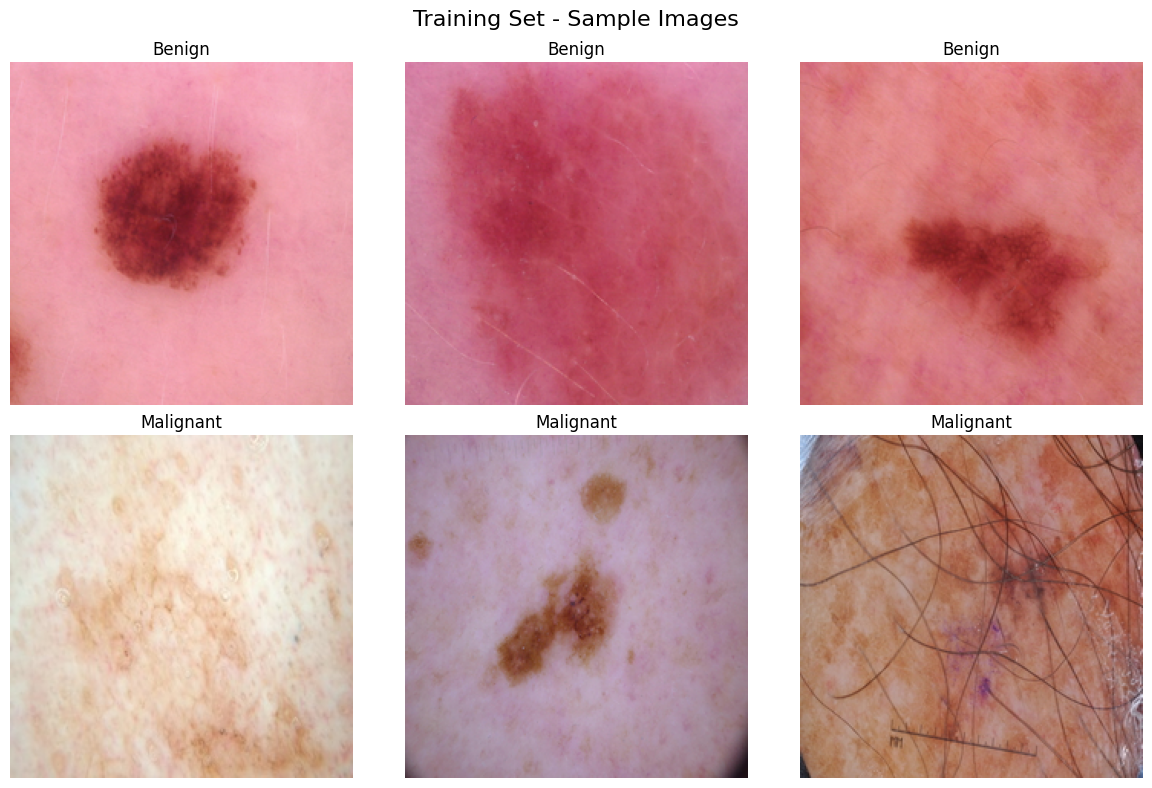


Dataset loading completed successfully!

Variables created:
- X_train: Training images
- X_test: Test images
- y_train: Training labels (0=benign, 1=malignant)
- y_test: Test labels (0=benign, 1=malignant)


In [89]:
# Display sample images from training set
print("\n=== Displaying Sample Training Images ===")
display_sample_images(X_train, y_train, "Training Set - Sample Images")

print("\nDataset loading completed successfully!")
print("\nVariables created:")
print("- X_train: Training images")
print("- X_test: Test images")
print("- y_train: Training labels (0=benign, 1=malignant)")
print("- y_test: Test labels (0=benign, 1=malignant)")

**Dataset Preparation**

In [90]:
# Import additional libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np

In [91]:
# Step 1: One-hot Encoding
print("1. Converting labels to one-hot encoding...")

# Create label encoder
label_encoder = LabelEncoder()

# Fit and transform training labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding using PyTorch
y_train_onehot = F.one_hot(torch.tensor(y_train_encoded), num_classes=2).float().numpy()
y_test_onehot = F.one_hot(torch.tensor(y_test_encoded), num_classes=2).float().numpy()

print(f"Original labels shape: {y_train.shape}")
print(f"One-hot encoded labels shape: {y_train_onehot.shape}")
print(f"Label mapping: {dict(enumerate(label_encoder.classes_))}")

1. Converting labels to one-hot encoding...
Original labels shape: (1000,)
One-hot encoded labels shape: (1000, 2)
Label mapping: {0: np.int64(0), 1: np.int64(1)}


In [92]:
# Show examples
print(f"Example - Original: {y_train[:5]} -> One-hot: {y_train_onehot[:5]}")

Example - Original: [0 0 0 0 0] -> One-hot: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [93]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_onehot,
    test_size=0.3,           # 30% for validation
    random_state=42,
    stratify=y_train_encoded  # Stratified sampling to maintain class balance
)

In [94]:
print(f"Final training set: {len(X_train_final)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Final training set: 700 images
Validation set: 300 images
Test set: 660 images


In [95]:
# Check class distribution
print(f"\nClass distribution in final training set:")
print(f"  Benign: {np.sum(np.argmax(y_train_final, axis=1) == 0)}")
print(f"  Malignant: {np.sum(np.argmax(y_train_final, axis=1) == 1)}")


Class distribution in final training set:
  Benign: 350
  Malignant: 350


In [96]:
print(f"\nClass distribution in validation set:")
print(f"  Benign: {np.sum(np.argmax(y_val, axis=1) == 0)}")
print(f"  Malignant: {np.sum(np.argmax(y_val, axis=1) == 1)}")


Class distribution in validation set:
  Benign: 150
  Malignant: 150


In [97]:
# Data Augmentation using PyTorch transforms
print("   Setting up data augmentation...")
print("   Rotation range: 15 degrees (as mentioned in paper)")

# Create data augmentation transforms for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),          # Rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Flip images horizontally
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Color jittering
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1),  # Translation and shear
    transforms.ToTensor(),
])

# Validation and test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

print("Data augmentation parameters:")
print(f"  - Rotation range: 15°")
print(f"  - Horizontal flip: 50% probability")
print(f"  - Color jitter: brightness/contrast ±10%")
print(f"  - Translation: ±10%")
print(f"  - Shear range: 10%")

   Setting up data augmentation...
   Rotation range: 15 degrees (as mentioned in paper)
Data augmentation parameters:
  - Rotation range: 15°
  - Horizontal flip: 50% probability
  - Color jitter: brightness/contrast ±10%
  - Translation: ±10%
  - Shear range: 10%


In [98]:
# Validation and test data generators (no augmentation, only rescaling)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1.0)
test_datagen = ImageDataGenerator(rescale=1.0)

print("Data augmentation parameters:")
print(f"  - Rotation range: 15°")
print(f"  - Width/Height shift: 10%")
print(f"  - Horizontal flip: Yes")
print(f"  - Zoom range: 10%")
print(f"  - Shear range: 10%")

Data augmentation parameters:
  - Rotation range: 15°
  - Width/Height shift: 10%
  - Horizontal flip: Yes
  - Zoom range: 10%
  - Shear range: 10%


In [99]:
BATCH_SIZE = 32

In [100]:
# Create PyTorch datasets and dataloaders
from torch.utils.data import Dataset, DataLoader

class SkinCancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to uint8 for PIL transforms
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image).permute(2, 0, 1).float() / 255.0  # HWC -> CHW and normalize

        # Convert one-hot label to class index for PyTorch
        if len(label.shape) > 0 and label.shape[0] > 1:  # one-hot encoded
            label = torch.tensor(np.argmax(label)).long()
        else:
            label = torch.tensor(label).long()

        return image, label

# Create datasets
train_dataset = SkinCancerDataset(X_train_final, y_train_final, transform=train_transform)
val_dataset = SkinCancerDataset(X_val, y_val, transform=val_test_transform)
test_dataset = SkinCancerDataset(X_test, y_test_onehot, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [101]:
print(f"   Data loaders created with batch size: {BATCH_SIZE}")
print(f"   Training batches per epoch: {len(train_loader)}")
print(f"   Validation batches per epoch: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

   Data loaders created with batch size: 32
   Training batches per epoch: 22
   Validation batches per epoch: 10
   Test batches: 21


   Displaying sample augmented images...


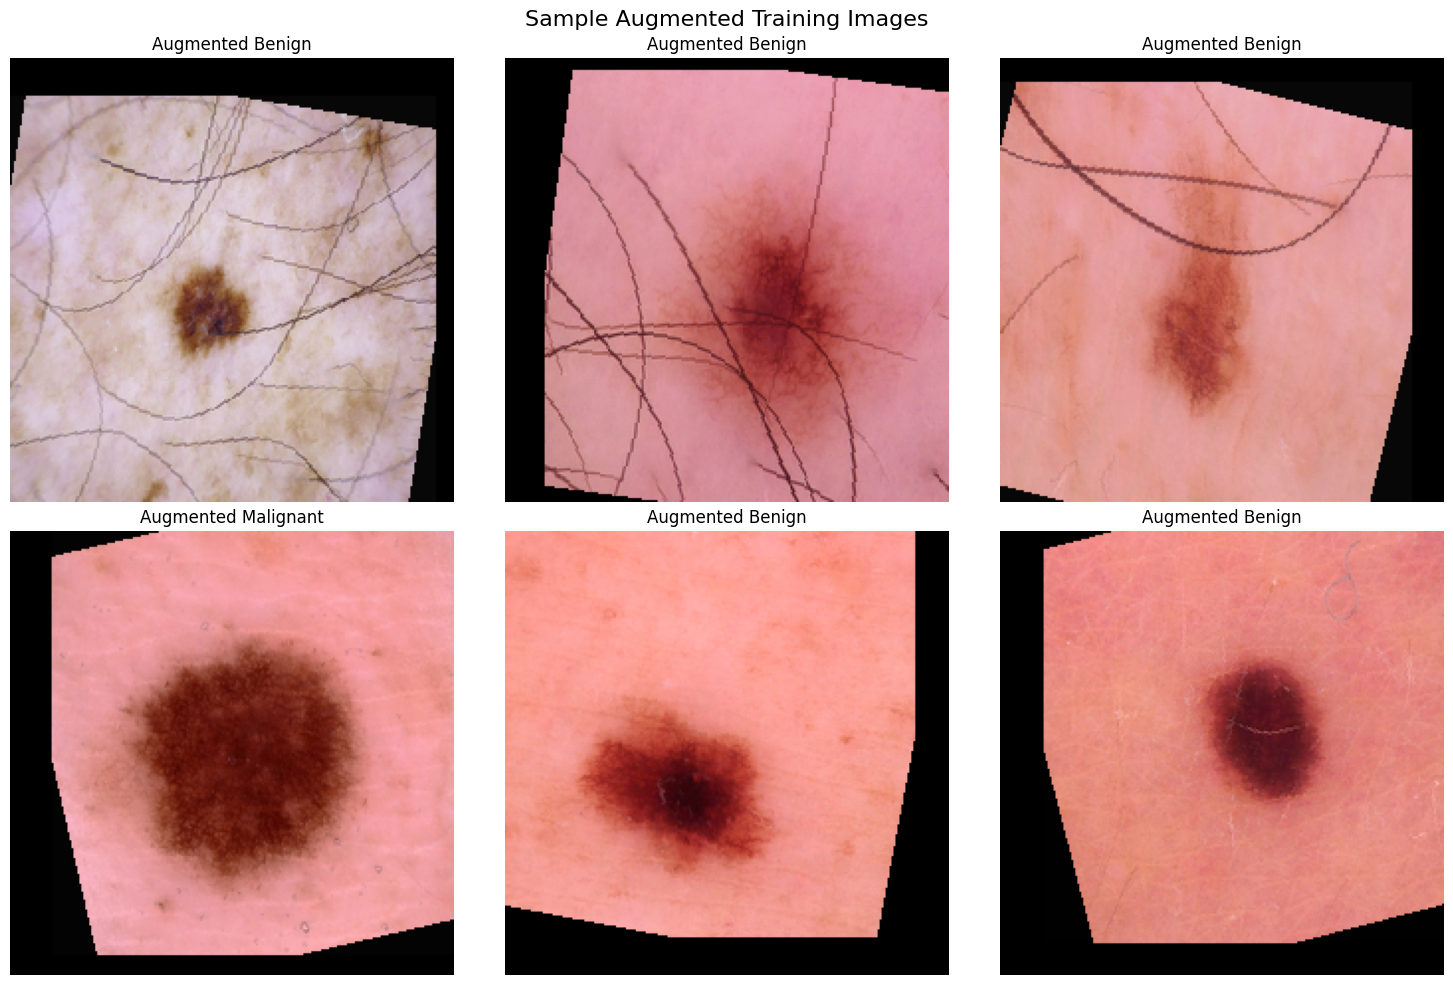

In [102]:
# Step 5: Visualize augmented images
import matplotlib.pyplot as plt

def show_augmented_images(dataloader, num_images=6):
    """Display original and augmented images"""
    # Get a batch from the dataloader
    dataiter = iter(dataloader)
    batch_images, batch_labels = next(dataiter)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(min(num_images, len(batch_images))):
        # Convert tensor to numpy for display (CHW -> HWC)
        img = batch_images[i].permute(1, 2, 0).numpy()
        # Ensure values are in [0,1] range for display
        img = np.clip(img, 0, 1)

        label = batch_labels[i].item()
        label_name = 'Malignant' if label == 1 else 'Benign'

        axes[i].imshow(img)
        axes[i].set_title(f'Augmented {label_name}')
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

print("   Displaying sample augmented images...")
show_augmented_images(train_loader)

In [103]:
# Reset the dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [104]:
# Step 6: Summary
print("\n=== Dataset Preparation Summary ===")
print("✓ Labels converted to one-hot encoding")
print("✓ Data split using stratified sampling (70% train, 30% validation)")
print("✓ Data augmentation applied to training set using PyTorch transforms")
print("✓ PyTorch DataLoaders created for training, validation, and testing")
print("\nDataset is ready for VGG-19 model training!")

print("\nVariables available for next step:")
print("- train_loader: Training data with augmentation")
print("- val_loader: Validation data")
print("- test_loader: Test data")
print("- X_train_final, y_train_final: Final training arrays")
print("- X_val, y_val: Validation arrays")
print("- X_test, y_test_onehot: Test arrays with one-hot labels")


=== Dataset Preparation Summary ===
✓ Labels converted to one-hot encoding
✓ Data split using stratified sampling (70% train, 30% validation)
✓ Data augmentation applied to training set using PyTorch transforms
✓ PyTorch DataLoaders created for training, validation, and testing

Dataset is ready for VGG-19 model training!

Variables available for next step:
- train_loader: Training data with augmentation
- val_loader: Validation data
- test_loader: Test data
- X_train_final, y_train_final: Final training arrays
- X_val, y_val: Validation arrays
- X_test, y_test_onehot: Test arrays with one-hot labels


**Transfer learning using VGG-19**

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [106]:
# Step 1: Load pre-trained VGG-19 base model
print("1. Loading pre-trained VGG-19 base model...")

# Load VGG-19 with pre-trained ImageNet weights
base_model = models.vgg19(weights='IMAGENET1K_V1')

print(f"VGG-19 base model loaded successfully")
print(f"Original classifier: {base_model.classifier}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

1. Loading pre-trained VGG-19 base model...
VGG-19 base model loaded successfully
Original classifier: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Using device: cuda


In [107]:
# Step 2: Freeze the base model layers
print("\n2. Freezing base model layers...")

# Freeze all parameters in features (convolutional layers)
for param in base_model.features.parameters():
    param.requires_grad = False

print(f"Base model features frozen")
print(f"Total feature layers: {len(list(base_model.features.children()))}")


2. Freezing base model layers...
Base model features frozen
Total feature layers: 37


In [108]:
# Step 3: Build the complete model with custom top layers
print("\n3. Building complete model with custom layers...")

class VGG19SkinCancer(nn.Module):
    def __init__(self, base_model, num_classes=2):
        super(VGG19SkinCancer, self).__init__()

        # Use VGG-19 features (convolutional layers)
        self.features = base_model.features

        # Adaptive pooling to handle different input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Custom classifier as described in paper
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),                    # Dropout for regularization (0.25 as mentioned in paper)
            nn.Linear(25088, 128),               # Dense layer with 128 neurons
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),                    # Dropout after first dense layer
            nn.Linear(128, 64),                  # Dense layer with 64 neurons
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),          # Output layer with 2 neurons (binary classification)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Create the complete model
model = VGG19SkinCancer(base_model, num_classes=2)
model = model.to(device)

print("✓ Model architecture created successfully")


3. Building complete model with custom layers...
✓ Model architecture created successfully


In [109]:
# Step 4: Display model summary
print("\n4. Model Summary:")
print(model)

# Create a sample input to get model statistics
sample_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    sample_output = model(sample_input)

print(f"\nModel input shape: {sample_input.shape}")
print(f"Model output shape: {sample_output.shape}")


4. Model Summary:
VGG19SkinCancer(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_s

In [110]:
# Count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
non_trainable_params = total_params - trainable_params

print(f"\nParameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


Parameter Summary:
Total parameters: 23,244,162
Trainable parameters: 3,219,778
Non-trainable parameters: 20,024,384


In [111]:
# Step 5: Setup optimizer and loss function
print("\n5. Setting up optimizer and loss function...")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

print("✓ Optimizer and loss function configured")
print("  - Loss function: CrossEntropyLoss")
print("  - Optimizer: Adam (lr=0.001)")


5. Setting up optimizer and loss function...
✓ Optimizer and loss function configured
  - Loss function: CrossEntropyLoss
  - Optimizer: Adam (lr=0.001)


In [112]:
# Step 6: Display model architecture details
print("\n6. Model Architecture Details:")
print("="*50)
print("VGG-19 Base Model (Frozen):")
print("- Pre-trained on ImageNet")
print("- 19 layers deep")
print("- Convolutional and MaxPooling layers")
print("- Features extracted using adaptive pooling")

print("\nCustom Classifier (Trainable):")
print("- Flatten layer: Convert 2D to 1D")
print("- Dropout: 0.25 (regularization)")
print("- Linear layer: 25088 -> 128 neurons, ReLU activation")
print("- Dropout: 0.25 (regularization)")
print("- Linear layer: 128 -> 64 neurons, ReLU activation")
print("- Output layer: 64 -> 2 neurons, no activation (raw logits)")


6. Model Architecture Details:
VGG-19 Base Model (Frozen):
- Pre-trained on ImageNet
- 19 layers deep
- Convolutional and MaxPooling layers
- Features extracted using adaptive pooling

Custom Classifier (Trainable):
- Flatten layer: Convert 2D to 1D
- Dropout: 0.25 (regularization)
- Linear layer: 25088 -> 128 neurons, ReLU activation
- Dropout: 0.25 (regularization)
- Linear layer: 128 -> 64 neurons, ReLU activation
- Output layer: 64 -> 2 neurons, no activation (raw logits)


In [113]:
# Step 7: Model architecture visualization (PyTorch)
print("\n7. Model Architecture:")
print("PyTorch model architecture visualization:")
print(f"- Model device: {next(model.parameters()).device}")
print(f"- Model mode: {'Training' if model.training else 'Evaluation'}")

# You can use torchsummary or torchinfo for detailed model summary if installed
try:
    from torchsummary import summary
    print("\nDetailed model summary:")
    summary(model, (3, 224, 224))
except ImportError:
    print("\n! torchsummary not installed. Install with: pip install torchsummary")
    print("Model structure displayed above.")


7. Model Architecture:
PyTorch model architecture visualization:
- Model device: cuda:0
- Model mode: Training

Detailed model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          

In [114]:
# Step 8: Setup training callbacks/schedulers
print("\n8. Setting up training schedulers...")

# Learning rate scheduler (equivalent to ReduceLROnPlateau)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=3,
    min_lr=1e-4
)

# Early stopping parameters (will be implemented in training loop)
early_stopping_patience = 5
best_val_acc = 0.0
patience_counter = 0

print("✓ Training schedulers configured:")
print("  - Learning rate reduction: factor=0.2, patience=3")
print("  - Early stopping: patience=5")
print("  - Best model weights will be saved automatically")


8. Setting up training schedulers...
✓ Training schedulers configured:
  - Learning rate reduction: factor=0.2, patience=3
  - Early stopping: patience=5
  - Best model weights will be saved automatically


In [115]:
# Step 9: Display training information
print("\n9. Training Setup Complete!")
print("="*50)
print("Model is ready for training with:")
print(f"- Model device: {device}")
print(f"- Loss function: CrossEntropyLoss")
print(f"- Optimizer: Adam (lr=0.001)")
print(f"- Scheduler: ReduceLROnPlateau")

print(f"\nTraining data ready:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Test samples: {len(test_dataset)}")
print(f"- Batch size: {BATCH_SIZE}")

print("\nNext step: Train the model!")
print("Variables available:")
print("- model: Complete VGG-19 transfer learning model")
print("- optimizer: Adam optimizer")
print("- criterion: CrossEntropyLoss")
print("- scheduler: Learning rate scheduler")
print("- train_loader: Training data")
print("- val_loader: Validation data")


9. Training Setup Complete!
Model is ready for training with:
- Model device: cuda
- Loss function: CrossEntropyLoss
- Optimizer: Adam (lr=0.001)
- Scheduler: ReduceLROnPlateau

Training data ready:
- Training samples: 700
- Validation samples: 300
- Test samples: 660
- Batch size: 32

Next step: Train the model!
Variables available:
- model: Complete VGG-19 transfer learning model
- optimizer: Adam optimizer
- criterion: CrossEntropyLoss
- scheduler: Learning rate scheduler
- train_loader: Training data
- val_loader: Validation data


In [116]:
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from tqdm import tqdm

In [117]:
# Step 1: Set training parameters as mentioned in paper
print("1. Setting training parameters...")

LEARNING_RATE = 0.0001  # Learning rate set to 0.0001 as mentioned in paper
EPOCHS = 15             # Number of iterations set to 15 as mentioned in paper
BATCH_SIZE = 32         # Batch size set to 32 as mentioned in paper

print(f"Training parameters:")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Optimizer: Adam")
print(f"- Loss function: CrossEntropyLoss")
print(f"- Metric: Accuracy")

1. Setting training parameters...
Training parameters:
- Learning rate: 0.0001
- Epochs: 15
- Batch size: 32
- Optimizer: Adam
- Loss function: CrossEntropyLoss
- Metric: Accuracy


In [118]:
# Step 2: Update optimizer with specified learning rate
print("\n2. Updating optimizer with specified parameters...")

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer with lr=0.0001
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

print("✓ Optimizer updated successfully")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Loss function: CrossEntropyLoss")


2. Updating optimizer with specified parameters...
✓ Optimizer updated successfully
  - Learning rate: 0.0001
  - Loss function: CrossEntropyLoss


In [119]:
# Step 3: Display training setup
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

print(f"\nTraining setup:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Steps per epoch: {steps_per_epoch}")
print(f"- Validation steps: {validation_steps}")
print(f"- Device: {device}")


Training setup:
- Training samples: 700
- Validation samples: 300
- Steps per epoch: 22
- Validation steps: 10
- Device: cuda


In [120]:
# Step 4: Start training
print(f"\n3. Starting model training for {EPOCHS} epochs...")
print("="*60)

# Record training start time
start_time = time.time()

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 30)

    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate averages
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_acc)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vgg19_skin_cancer_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break

# Record training end time
end_time = time.time()
training_time = end_time - start_time

print(f"\n✓ Training completed!")
print(f"Total training time: {training_time/60:.2f} minutes")


3. Starting model training for 15 epochs...

Epoch 1/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Train Loss: 0.6734, Train Acc: 0.5957
Val Loss: 0.6302, Val Acc: 0.6800

Epoch 2/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Train Loss: 0.5981, Train Acc: 0.7271
Val Loss: 0.5575, Val Acc: 0.7600

Epoch 3/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Train Loss: 0.5133, Train Acc: 0.7886
Val Loss: 0.5709, Val Acc: 0.7600

Epoch 4/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Train Loss: 0.4716, Train Acc: 0.7929
Val Loss: 0.5838, Val Acc: 0.7667

Epoch 5/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Train Loss: 0.4466, Train Acc: 0.8057
Val Loss: 0.5955, Val Acc: 0.7833

Epoch 6/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Train Loss: 0.4299, Train Acc: 0.8200
Val Loss: 0.5483, Val Acc: 0.7800

Epoch 7/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Train Loss: 0.3913, Train Acc: 0.8357
Val Loss: 0.5477, Val Acc: 0.7933

Epoch 8/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Train Loss: 0.3859, Train Acc: 0.8386
Val Loss: 0.5376, Val Acc: 0.7933

Epoch 9/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Train Loss: 0.3748, Train Acc: 0.8286
Val Loss: 0.5177, Val Acc: 0.7867

Epoch 10/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Train Loss: 0.3852, Train Acc: 0.8229
Val Loss: 0.4975, Val Acc: 0.8100

Epoch 11/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Train Loss: 0.3657, Train Acc: 0.8343
Val Loss: 0.5344, Val Acc: 0.7967

Epoch 12/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Train Loss: 0.3489, Train Acc: 0.8557
Val Loss: 0.5108, Val Acc: 0.8100

Epoch 13/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Train Loss: 0.3290, Train Acc: 0.8586
Val Loss: 0.5675, Val Acc: 0.7833

Epoch 14/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Train Loss: 0.3040, Train Acc: 0.8743
Val Loss: 0.5818, Val Acc: 0.7800

Epoch 15/15
------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

Train Loss: 0.3251, Train Acc: 0.8614
Val Loss: 0.5287, Val Acc: 0.7967

Early stopping triggered after 15 epochs

✓ Training completed!
Total training time: 1.74 minutes


In [121]:
# Step 5: Display training results
print(f"\n4. Training Results Summary:")
print("="*50)

# Get final epoch results
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")


4. Training Results Summary:
Final Training Accuracy: 0.8614 (86.14%)
Final Validation Accuracy: 0.7967 (79.67%)
Final Training Loss: 0.3251
Final Validation Loss: 0.5287
Best Validation Accuracy: 0.8100 (81.00%)


   Plotting training history...


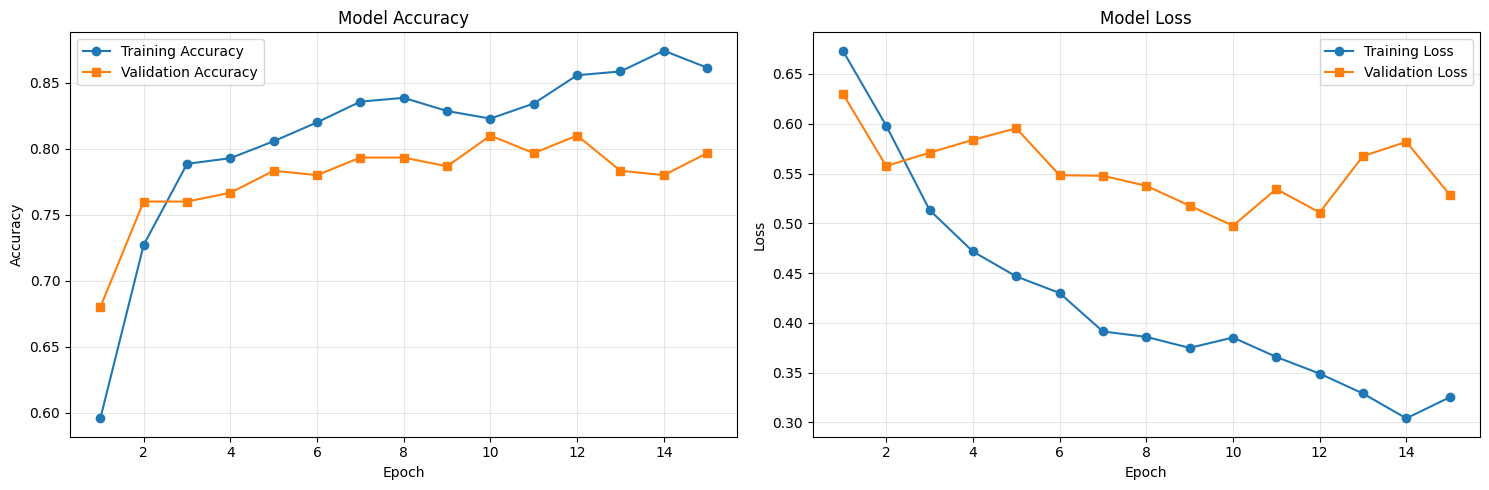

In [122]:
# Step 6: Plot training history
print(f"   Plotting training history...")

def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_acc']) + 1)

    # Plot accuracy
    ax1.plot(epochs, history['train_acc'], label='Training Accuracy', marker='o')
    ax1.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
    ax2.plot(epochs, history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [123]:
# Step 7: Evaluate model on test set
print(f"\n6. Evaluating model on test set...")

# Load best model
model.load_state_dict(torch.load('best_vgg19_skin_cancer_model.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total

print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")


6. Evaluating model on test set...


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Test Results:
Test Accuracy: 0.8197 (81.97%)
Test Loss: 0.4396


In [124]:
# Step 8: Display detailed training metrics
print(f"\n7. Detailed Training Metrics:")
print("="*50)
print(f"{'Epoch':<6} {'Train Acc':<10} {'Val Acc':<10} {'Train Loss':<12} {'Val Loss':<10}")
print("-"*50)

for i in range(len(history['train_acc'])):
    epoch = i + 1
    train_acc = history['train_acc'][i]
    val_acc = history['val_acc'][i]
    train_loss = history['train_loss'][i]
    val_loss = history['val_loss'][i]

    print(f"{epoch:<6} {train_acc:<10.4f} {val_acc:<10.4f} {train_loss:<12.4f} {val_loss:<10.4f}")


7. Detailed Training Metrics:
Epoch  Train Acc  Val Acc    Train Loss   Val Loss  
--------------------------------------------------
1      0.5957     0.6800     0.6734       0.6302    
2      0.7271     0.7600     0.5981       0.5575    
3      0.7886     0.7600     0.5133       0.5709    
4      0.7929     0.7667     0.4716       0.5838    
5      0.8057     0.7833     0.4466       0.5955    
6      0.8200     0.7800     0.4299       0.5483    
7      0.8357     0.7933     0.3913       0.5477    
8      0.8386     0.7933     0.3859       0.5376    
9      0.8286     0.7867     0.3748       0.5177    
10     0.8229     0.8100     0.3852       0.4975    
11     0.8343     0.7967     0.3657       0.5344    
12     0.8557     0.8100     0.3489       0.5108    
13     0.8586     0.7833     0.3290       0.5675    
14     0.8743     0.7800     0.3040       0.5818    
15     0.8614     0.7967     0.3251       0.5287    


In [125]:
# Step 9: Save the trained model
print(f"\n8. Saving the trained model...")

# Save complete model
torch.save(model.state_dict(), 'vgg19_skin_cancer_model.pth')
# Also save the complete model for easy loading
torch.save(model, 'vgg19_skin_cancer_complete_model.pth')

print("✓ Model saved as 'vgg19_skin_cancer_model.pth' (state dict)")
print("✓ Complete model saved as 'vgg19_skin_cancer_complete_model.pth'")


8. Saving the trained model...
✓ Model saved as 'vgg19_skin_cancer_model.pth' (state dict)
✓ Complete model saved as 'vgg19_skin_cancer_complete_model.pth'


In [126]:
# Step 10: Training summary
print(f"\n9. Training Summary:")
print("="*50)
print(f"✓ Model trained successfully for {len(history['train_acc'])} epochs")
print(f"✓ Training time: {training_time/60:.2f} minutes")
print(f"✓ Best validation accuracy: {best_val_acc:.4f}")
print(f"✓ Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

if test_accuracy >= 0.85:  # Check if close to paper's 88% accuracy
    print(f"✓ Model achieved good performance (≥85% accuracy)")
    print("✓ Model is ready for adversarial attack testing!")
else:
    print(f"! Model accuracy is below 85%. Consider:")
    print("  - Training for more epochs")
    print("  - Adjusting learning rate")
    print("  - Fine-tuning hyperparameters")

print(f"\nVariables created:")
print("- history: Training history with metrics")
print("- model: Trained VGG-19 model")
print(f"- test_accuracy: Final test accuracy ({test_accuracy:.4f})")

print(f"\nNext step: Implement FGSM adversarial attack!")
print("="*60)


9. Training Summary:
✓ Model trained successfully for 15 epochs
✓ Training time: 1.74 minutes
✓ Best validation accuracy: 0.8100
✓ Final test accuracy: 0.8197 (81.97%)
! Model accuracy is below 85%. Consider:
  - Training for more epochs
  - Adjusting learning rate
  - Fine-tuning hyperparameters

Variables created:
- history: Training history with metrics
- model: Trained VGG-19 model
- test_accuracy: Final test accuracy (0.8197)

Next step: Implement FGSM adversarial attack!


**Results**

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import torch

In [128]:
# Step 1: Make predictions on test set
print("1. Making predictions on test set...")

# Ensure model is in evaluation mode
model.eval()

test_predictions = []
test_true_classes = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Making predictions"):
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)
        test_predictions.extend(probabilities.cpu().numpy())
        test_true_classes.extend(labels.numpy())

test_predictions = np.array(test_predictions)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.array(test_true_classes)

print(f"✓ Predictions completed")
print(f"Test samples: {len(test_pred_classes)}")

1. Making predictions on test set...


Making predictions: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]

✓ Predictions completed
Test samples: 660


In [129]:
# Define class names
class_names = ['Benign', 'Malignant']

# Generate classification report
report = classification_report(
    test_true_classes,
    test_pred_classes,
    target_names=class_names,
    output_dict=True
)

# Create formatted classification report table
print(f"Classification Results of the Trained Model")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print("-"*70)

for class_name in class_names:
    precision = report[class_name]['precision'] * 100
    recall = report[class_name]['recall'] * 100
    f1 = report[class_name]['f1-score'] * 100
    support = int(report[class_name]['support'])

    print(f"{class_name:<12} {precision:<12.0f}% {recall:<12.0f}% {f1:<12.0f}% {support:<12}")

# Overall accuracy
overall_accuracy = report['accuracy'] * 100
print("-"*70)
print(f"{'Overall':<12} {'Accuracy:':<12} {overall_accuracy:<12.0f}%")

Classification Results of the Trained Model
Class        Precision    Recall       F1-Score     Support     
----------------------------------------------------------------------
Benign       94          % 72          % 81          % 360         
Malignant    74          % 94          % 83          % 300         
----------------------------------------------------------------------
Overall      Accuracy:    82          %


In [130]:
# Step 3: Display detailed metrics as mentioned in paper
print(f"   Detailed Performance Analysis:")
print("="*50)

precision_benign = report['Benign']['precision'] * 100
precision_malignant = report['Malignant']['precision'] * 100
recall_benign = report['Benign']['recall'] * 100
recall_malignant = report['Malignant']['recall'] * 100
f1_benign = report['Benign']['f1-score'] * 100
f1_malignant = report['Malignant']['f1-score'] * 100

print(f"PRECISION (Model's accuracy of positive predictions):")
print(f"- Benign images correctly predicted: {precision_benign:.0f}%")
print(f"- Malignant images correctly predicted: {precision_malignant:.0f}%")

print(f"\nRECALL (Ability to find all positive instances):")
print(f"- Benign recall: {recall_benign:.0f}%")
print(f"- Malignant recall: {recall_malignant:.0f}%")

print(f"\nF1-SCORE (Percentage of positive predictions that were correct):")
print(f"- Benign F1-score: {f1_benign:.0f}%")
print(f"- Malignant F1-score: {f1_malignant:.0f}%")

print(f"\nSUPPORT (Number of actual occurrences):")
print(f"- Benign images: {int(report['Benign']['support'])}")
print(f"- Malignant images: {int(report['Malignant']['support'])}")

   Detailed Performance Analysis:
PRECISION (Model's accuracy of positive predictions):
- Benign images correctly predicted: 94%
- Malignant images correctly predicted: 74%

RECALL (Ability to find all positive instances):
- Benign recall: 72%
- Malignant recall: 94%

F1-SCORE (Percentage of positive predictions that were correct):
- Benign F1-score: 81%
- Malignant F1-score: 83%

SUPPORT (Number of actual occurrences):
- Benign images: 360
- Malignant images: 300


   Creating Training Loss and Accuracy Graph (Figure 2)...


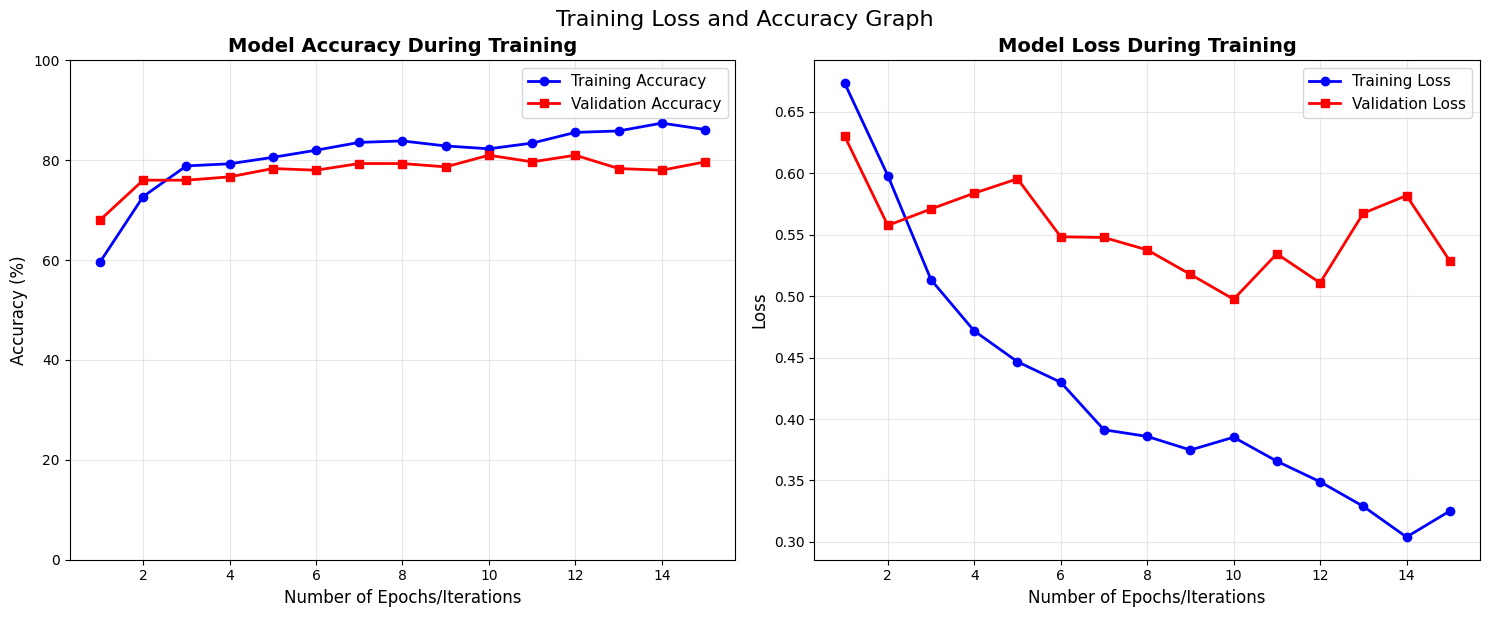

In [131]:
# Step 4: Create Training Loss and Accuracy Graph (Figure 2)
print(f"   Creating Training Loss and Accuracy Graph (Figure 2)...")

def plot_training_results():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Fixed: Use PyTorch history format (simple dict) instead of TensorFlow history.history
    epochs_range = range(1, len(history['train_acc']) + 1)

    # Plot Training and Validation Accuracy
    ax1.plot(epochs_range, [acc*100 for acc in history['train_acc']],
             'b-o', label='Training Accuracy', linewidth=2, markersize=6)
    ax1.plot(epochs_range, [acc*100 for acc in history['val_acc']],
             'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
    ax1.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Epochs/Iterations', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])

    # Plot Training and Validation Loss
    ax2.plot(epochs_range, history['train_loss'],
             'b-o', label='Training Loss', linewidth=2, markersize=6)
    ax2.plot(epochs_range, history['val_loss'],
             'r-s', label='Validation Loss', linewidth=2, markersize=6)
    ax2.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Epochs/Iterations', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Training Loss and Accuracy Graph', fontsize=16, y=1.02)
    plt.show()

plot_training_results()

   Creating Confusion Matrix (Figure 3)...


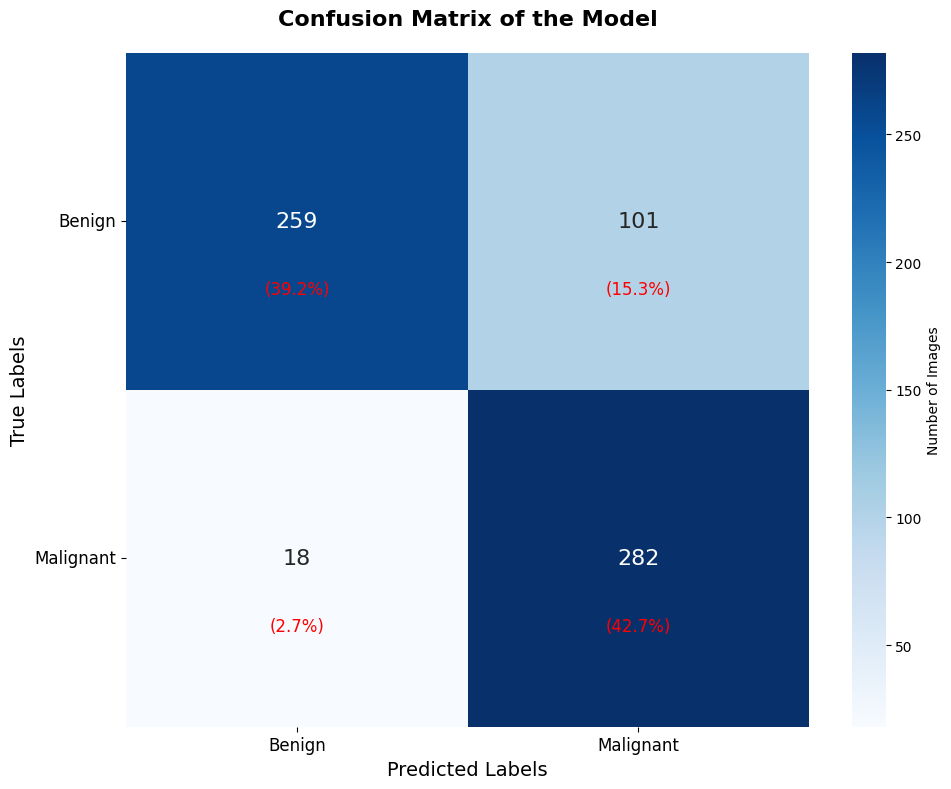

In [132]:
# Step 5: Create Confusion Matrix (Figure 3)
print(f"   Creating Confusion Matrix (Figure 3)...")

def plot_confusion_matrix():
    """Create Figure 3: Confusion matrix"""
    # Calculate confusion matrix
    cm = confusion_matrix(test_true_classes, test_pred_classes)

    # Create confusion matrix plot
    plt.figure(figsize=(10, 8))

    # Use seaborn for better visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={'size': 16}, cbar_kws={'label': 'Number of Images'})

    plt.title('Confusion Matrix of the Model', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)

    # Add percentage annotations
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            percentage = (cm[i, j] / total) * 100
            plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

    return cm

cm = plot_confusion_matrix()

In [133]:
# Step 6: Calculate and display confusion matrix metrics
print(f"Confusion Matrix Analysis:")
print("="*50)

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate rates as mentioned in paper
benign_true_positive_rate = (cm[0,0] / (cm[0,0] + cm[0,1])) * 100
benign_false_positive_rate = (cm[0,1] / (cm[0,0] + cm[0,1])) * 100

malignant_true_negative_rate = (cm[1,1] / (cm[1,0] + cm[1,1])) * 100
malignant_false_negative_rate = (cm[1,0] / (cm[1,0] + cm[1,1])) * 100

print(f"BENIGN Classification:")
print(f"- True Positive Rate: {benign_true_positive_rate:.0f}% ({cm[0,0]} images)")
print(f"- False Positive Rate: {benign_false_positive_rate:.0f}% ({cm[0,1]} images)")

print(f"\nMALIGNANT Classification:")
print(f"- True Negative Rate: {malignant_true_negative_rate:.0f}% ({cm[1,1]} images)")
print(f"- False Negative Rate: {malignant_false_negative_rate:.0f}% ({cm[1,0]} images)")

Confusion Matrix Analysis:
BENIGN Classification:
- True Positive Rate: 72% (259 images)
- False Positive Rate: 28% (101 images)

MALIGNANT Classification:
- True Negative Rate: 94% (282 images)
- False Negative Rate: 6% (18 images)


In [134]:
# Step 7: Summary of Results
print(f"RESULTS SUMMARY:")
print("="*60)
print(f"✓ Overall Model Accuracy: {overall_accuracy:.0f}%")
print(f"✓ High classification accuracy achieved")
print(f"✓ Model demonstrates strong performance on both classes")
print(f"✓ Training and validation curves show good learning progression")
print(f"✓ Minimal overfitting observed")

# Create summary table
summary_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support'],
    'Benign': [f"{precision_benign:.0f}%", f"{recall_benign:.0f}%",
               f"{f1_benign:.0f}%", f"{int(report['Benign']['support'])}"],
    'Malignant': [f"{precision_malignant:.0f}%", f"{recall_malignant:.0f}%",
                  f"{f1_malignant:.0f}%", f"{int(report['Malignant']['support'])}"]
}

summary_df = pd.DataFrame(summary_data)
print(f"\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))

print(f"\n✓ Model is ready for adversarial attack testing!")
print(f"✓ Current accuracy ({overall_accuracy:.0f}%) will be compared against")
print(f"  post-attack accuracy to demonstrate FGSM impact")

print(f"\nVariables created:")
print("- test_pred_classes: Model predictions on test set")
print("- test_true_classes: True labels for test set")
print("- report: Classification report dictionary")
print("- cm: Confusion matrix")
print("="*60)

RESULTS SUMMARY:
✓ Overall Model Accuracy: 82%
✓ High classification accuracy achieved
✓ Model demonstrates strong performance on both classes
✓ Training and validation curves show good learning progression
✓ Minimal overfitting observed

SUMMARY TABLE:
   Metric Benign Malignant
Precision    94%       74%
   Recall    72%       94%
 F1-Score    81%       83%
  Support    360       300

✓ Model is ready for adversarial attack testing!
✓ Current accuracy (82%) will be compared against
  post-attack accuracy to demonstrate FGSM impact

Variables created:
- test_pred_classes: Model predictions on test set
- test_true_classes: True labels for test set
- report: Classification report dictionary
- cm: Confusion matrix


In [135]:
"""
Implementing FGSM Attack to the Trained CNN
 In Part 1, we focused on training the VGG-19 model with a
 medical dataset to accurately classify the benign and malignant
 skin-cancer images. In Part 2, we will focus on generating the
 adversarial attack and implementing it to the system.

 1) Generating Image Adversary: To implement the attack,
 we first generated an image adversary and recorded our
 gradients. We used our model to make predictions on the input
 image and then compute the loss. From there, we calculate the
 gradient of loss and compute the sign of the gradient. Then, we
 construct the image adversary by adding the image with the
 sign of the gradient. Fig. 1 illustrates the difference between
 the original image and an adversarial image from a sample
 image of the dataset.
 Fig. 1. Comparison of the original image and an adversarial image.
 After the adversarial image was created, it was sent to the
 trained model to classify the images. The evaluation of the
 model after the attack, is reported in Section IV.
"""

'\nImplementing FGSM Attack to the Trained CNN\n In Part 1, we focused on training the VGG-19 model with a\n medical dataset to accurately classify the benign and malignant\n skin-cancer images. In Part 2, we will focus on generating the\n adversarial attack and implementing it to the system.\n\n 1) Generating Image Adversary: To implement the attack,\n we first generated an image adversary and recorded our\n gradients. We used our model to make predictions on the input\n image and then compute the loss. From there, we calculate the\n gradient of loss and compute the sign of the gradient. Then, we\n construct the image adversary by adding the image with the\n sign of the gradient. Fig. 1 illustrates the difference between\n the original image and an adversarial image from a sample\n image of the dataset.\n Fig. 1. Comparison of the original image and an adversarial image.\n After the adversarial image was created, it was sent to the\n trained model to classify the images. The evaluatio

In [136]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Part 2 - Implementing FGSM Attack to the Trained CNN

def create_adversarial_pattern(input_image, input_label, model, device):
    """
    Create adversarial pattern using FGSM attack
    """
    # Ensure input requires gradients
    input_image = input_image.clone().detach().requires_grad_(True).to(device)
    input_label = input_label.to(device)

    # Forward pass
    output = model(input_image)

    # Calculate loss
    loss = F.cross_entropy(output, input_label)

    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()

    # Get the sign of the gradients to create the perturbation
    gradient = input_image.grad.data
    signed_grad = gradient.sign()

    return signed_grad

def generate_adversarial_examples(model, test_loader, device, epsilon=0.01):
    """
    Generate adversarial examples using FGSM attack

    Args:
        model: Trained CNN model
        test_loader: PyTorch DataLoader for test data
        device: Device (cpu/cuda)
        epsilon: Perturbation magnitude

    Returns:
        adversarial_images: Generated adversarial examples
        original_images: Original images
        true_labels: True labels
    """
    print(f"Generating adversarial examples with epsilon = {epsilon}...")

    model.eval()
    adversarial_images = []
    original_images = []
    true_labels = []

    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Generating adversarial examples")):
        images = images.to(device)
        labels = labels.to(device)

        # Create adversarial pattern
        perturbations = create_adversarial_pattern(images, labels, model, device)

        # Create adversarial images
        adversarial_batch = images + epsilon * perturbations

        # Clip to valid pixel range [0, 1]
        adversarial_batch = torch.clamp(adversarial_batch, 0, 1)

        # Store results
        adversarial_images.extend(adversarial_batch.cpu().detach().numpy())
        original_images.extend(images.cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())

    return np.array(adversarial_images), np.array(original_images), np.array(true_labels)

def evaluate_adversarial_attack(model, X_original, X_adversarial, y_true, class_names, device):
    """
    Evaluate the impact of adversarial attack

    Args:
        model: Trained CNN model
        X_original: Original test images
        X_adversarial: Adversarial test images
        y_true: True labels
        class_names: List of class names
        device: Device (cpu/cuda)
    """
    print("\n" + "="*50)
    print("EVALUATING ADVERSARIAL ATTACK IMPACT")
    print("="*50)

    model.eval()

    # Get predictions for original images
    print("Making predictions on original images...")
    original_predictions = []
    with torch.no_grad():
        for i in range(0, len(X_original), 32):  # Process in batches
            batch = torch.tensor(X_original[i:i+32]).to(device)
            outputs = model(batch)
            predictions = torch.softmax(outputs, dim=1)
            original_predictions.extend(predictions.cpu().numpy())

    original_predictions = np.array(original_predictions)
    original_pred_classes = np.argmax(original_predictions, axis=1)

    # Get predictions for adversarial images
    print("Making predictions on adversarial images...")
    adversarial_predictions = []
    with torch.no_grad():
        for i in range(0, len(X_adversarial), 32):  # Process in batches
            batch = torch.tensor(X_adversarial[i:i+32]).to(device)
            outputs = model(batch)
            predictions = torch.softmax(outputs, dim=1)
            adversarial_predictions.extend(predictions.cpu().numpy())

    adversarial_predictions = np.array(adversarial_predictions)
    adversarial_pred_classes = np.argmax(adversarial_predictions, axis=1)

    # Calculate accuracies
    original_accuracy = np.mean(original_pred_classes == y_true)
    adversarial_accuracy = np.mean(adversarial_pred_classes == y_true)

    print(f"\nOriginal Model Accuracy: {original_accuracy:.2%}")
    print(f"Adversarial Model Accuracy: {adversarial_accuracy:.2%}")
    print(f"Accuracy Drop: {original_accuracy - adversarial_accuracy:.2%}")

    return original_pred_classes, adversarial_pred_classes

def plot_confusion_matrices(original_pred, adversarial_pred, true_labels, class_names):
    """
    Plot confusion matrices for original and adversarial predictions
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Original predictions confusion matrix
    cm_original = confusion_matrix(true_labels, original_pred)
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix - Original Images')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Adversarial predictions confusion matrix
    cm_adversarial = confusion_matrix(true_labels, adversarial_pred)
    sns.heatmap(cm_adversarial, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Confusion Matrix - Adversarial Images')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    return cm_original, cm_adversarial

def visualize_adversarial_examples(X_original, X_adversarial, y_true,
                                 original_pred, adversarial_pred, class_names, n_samples=6):
    """
    Visualize original vs adversarial images with predictions
    """
    # Find examples where adversarial attack succeeded (changed prediction)
    attack_success = (original_pred != adversarial_pred)
    success_indices = np.where(attack_success)[0]

    if len(success_indices) < n_samples:
        indices = success_indices
    else:
        indices = np.random.choice(success_indices, n_samples, replace=False)

    fig, axes = plt.subplots(2, len(indices), figsize=(15, 6))
    if len(indices) == 1:
        axes = axes.reshape(-1, 1)

    for i, idx in enumerate(indices):
        # Original image - convert from CHW to HWC for display
        orig_img = X_original[idx].transpose(1, 2, 0)
        axes[0, i].imshow(np.clip(orig_img, 0, 1))
        axes[0, i].set_title(f'Original\nTrue: {class_names[y_true[idx]]}\n'
                           f'Pred: {class_names[original_pred[idx]]}')
        axes[0, i].axis('off')

        # Adversarial image - convert from CHW to HWC for display
        adv_img = X_adversarial[idx].transpose(1, 2, 0)
        axes[1, i].imshow(np.clip(adv_img, 0, 1))
        axes[1, i].set_title(f'Adversarial\nTrue: {class_names[y_true[idx]]}\n'
                           f'Pred: {class_names[adversarial_pred[idx]]}')
        axes[1, i].axis('off')

    plt.suptitle('Original vs Adversarial Images Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

# Main execution code
def run_fgsm_attack(model, test_loader, device, class_names=['Benign', 'Malignant'], epsilon=0.01):
    """
    Main function to run FGSM attack

    Args:
        model: Your trained VGG-19 model
        test_loader: PyTorch DataLoader for test data
        device: Device (cpu/cuda)
        class_names: List of class names
        epsilon: Perturbation strength
    """
    print("Starting FGSM Attack Implementation...")
    print(f"Epsilon (perturbation strength): {epsilon}")

    # Step 1: Generate adversarial examples
    X_adversarial, X_original, true_labels = generate_adversarial_examples(model, test_loader, device, epsilon)

    # Step 2: Evaluate attack impact
    original_pred, adversarial_pred = evaluate_adversarial_attack(
        model, X_original, X_adversarial, true_labels, class_names, device
    )

    # Step 3: Plot confusion matrices
    print("\nGenerating confusion matrices...")
    cm_original, cm_adversarial = plot_confusion_matrices(
        original_pred, adversarial_pred, true_labels, class_names
    )

    # Step 4: Visualize some adversarial examples
    print("\nVisualizing adversarial examples...")
    visualize_adversarial_examples(
        X_original, X_adversarial, true_labels, original_pred, adversarial_pred, class_names
    )

    # Step 5: Print detailed classification report
    print("\nClassification Report - Original Images:")
    print(classification_report(true_labels, original_pred, target_names=class_names))

    print("\nClassification Report - Adversarial Images:")
    print(classification_report(true_labels, adversarial_pred, target_names=class_names))

    return X_adversarial, original_pred, adversarial_pred


PART 2: IMPLEMENTING FGSM ATTACK
Using device: cuda
Model is on device: cuda:0

Testing with Epsilon = 0.005
Starting FGSM Attack Implementation...
Epsilon (perturbation strength): 0.005
Generating adversarial examples with epsilon = 0.005...


Generating adversarial examples: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]



EVALUATING ADVERSARIAL ATTACK IMPACT
Making predictions on original images...
Making predictions on adversarial images...

Original Model Accuracy: 81.97%
Adversarial Model Accuracy: 6.06%
Accuracy Drop: 75.91%

Generating confusion matrices...


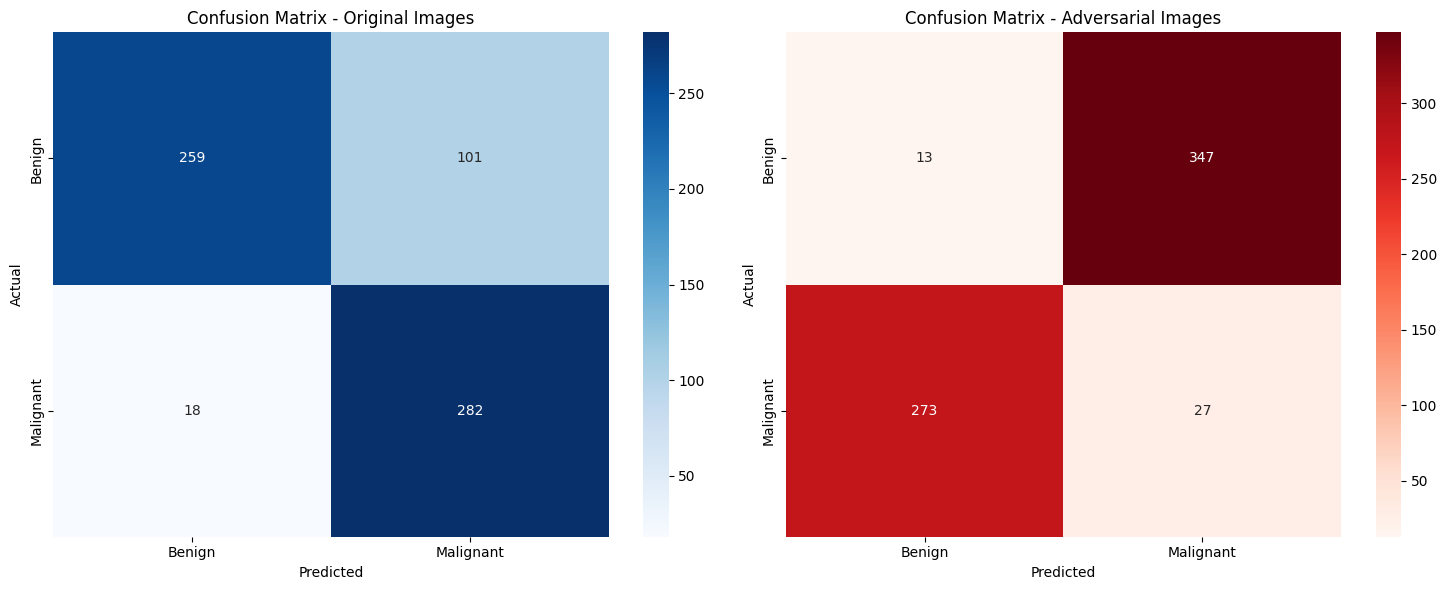


Visualizing adversarial examples...


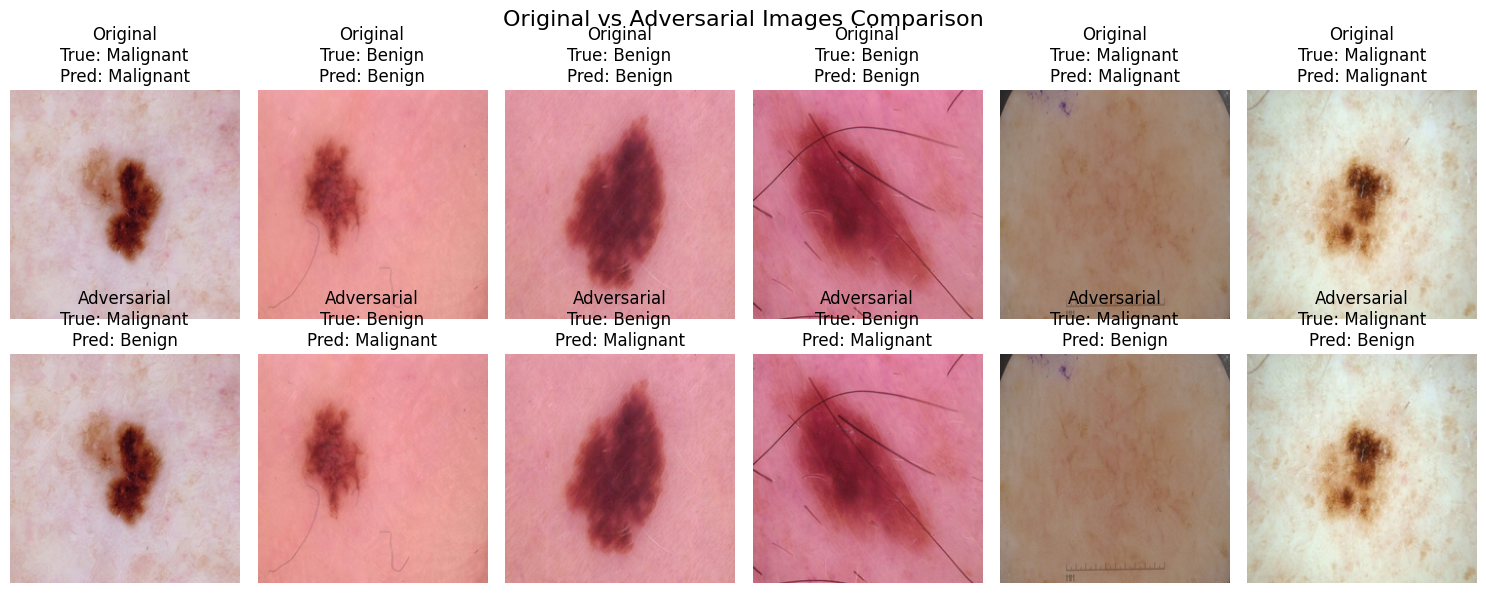


Classification Report - Original Images:
              precision    recall  f1-score   support

      Benign       0.94      0.72      0.81       360
   Malignant       0.74      0.94      0.83       300

    accuracy                           0.82       660
   macro avg       0.84      0.83      0.82       660
weighted avg       0.84      0.82      0.82       660


Classification Report - Adversarial Images:
              precision    recall  f1-score   support

      Benign       0.05      0.04      0.04       360
   Malignant       0.07      0.09      0.08       300

    accuracy                           0.06       660
   macro avg       0.06      0.06      0.06       660
weighted avg       0.06      0.06      0.06       660

Generating adversarial examples with epsilon = 0.005...


Generating adversarial examples: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]



SUMMARY for Epsilon = 0.005:
Original Accuracy: 82%
Adversarial Accuracy: 6%
Accuracy Drop: 76%

Testing with Epsilon = 0.01
Starting FGSM Attack Implementation...
Epsilon (perturbation strength): 0.01
Generating adversarial examples with epsilon = 0.01...


Generating adversarial examples: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]



EVALUATING ADVERSARIAL ATTACK IMPACT
Making predictions on original images...
Making predictions on adversarial images...

Original Model Accuracy: 81.97%
Adversarial Model Accuracy: 4.70%
Accuracy Drop: 77.27%

Generating confusion matrices...


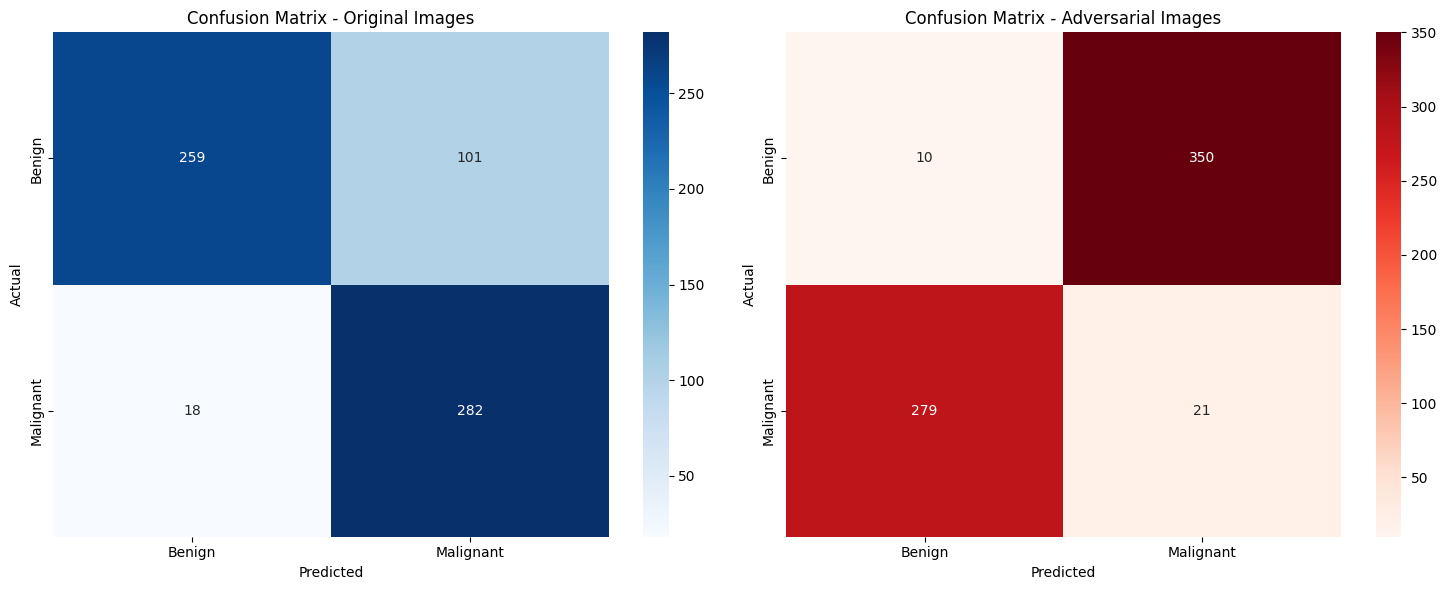


Visualizing adversarial examples...


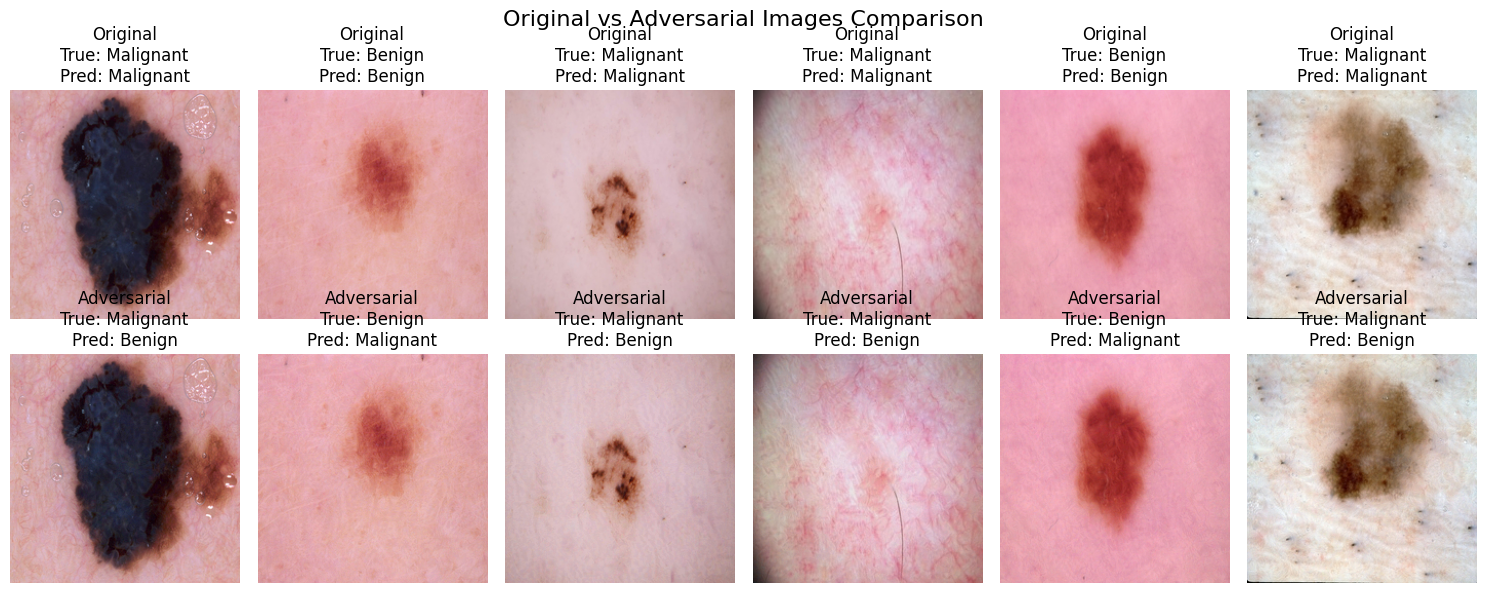


Classification Report - Original Images:
              precision    recall  f1-score   support

      Benign       0.94      0.72      0.81       360
   Malignant       0.74      0.94      0.83       300

    accuracy                           0.82       660
   macro avg       0.84      0.83      0.82       660
weighted avg       0.84      0.82      0.82       660


Classification Report - Adversarial Images:
              precision    recall  f1-score   support

      Benign       0.03      0.03      0.03       360
   Malignant       0.06      0.07      0.06       300

    accuracy                           0.05       660
   macro avg       0.05      0.05      0.05       660
weighted avg       0.04      0.05      0.05       660

Generating adversarial examples with epsilon = 0.01...


Generating adversarial examples: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]



SUMMARY for Epsilon = 0.01:
Original Accuracy: 82%
Adversarial Accuracy: 5%
Accuracy Drop: 77%

Testing with Epsilon = 0.013
Starting FGSM Attack Implementation...
Epsilon (perturbation strength): 0.013
Generating adversarial examples with epsilon = 0.013...


Generating adversarial examples: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]



EVALUATING ADVERSARIAL ATTACK IMPACT
Making predictions on original images...
Making predictions on adversarial images...

Original Model Accuracy: 81.97%
Adversarial Model Accuracy: 5.15%
Accuracy Drop: 76.82%

Generating confusion matrices...


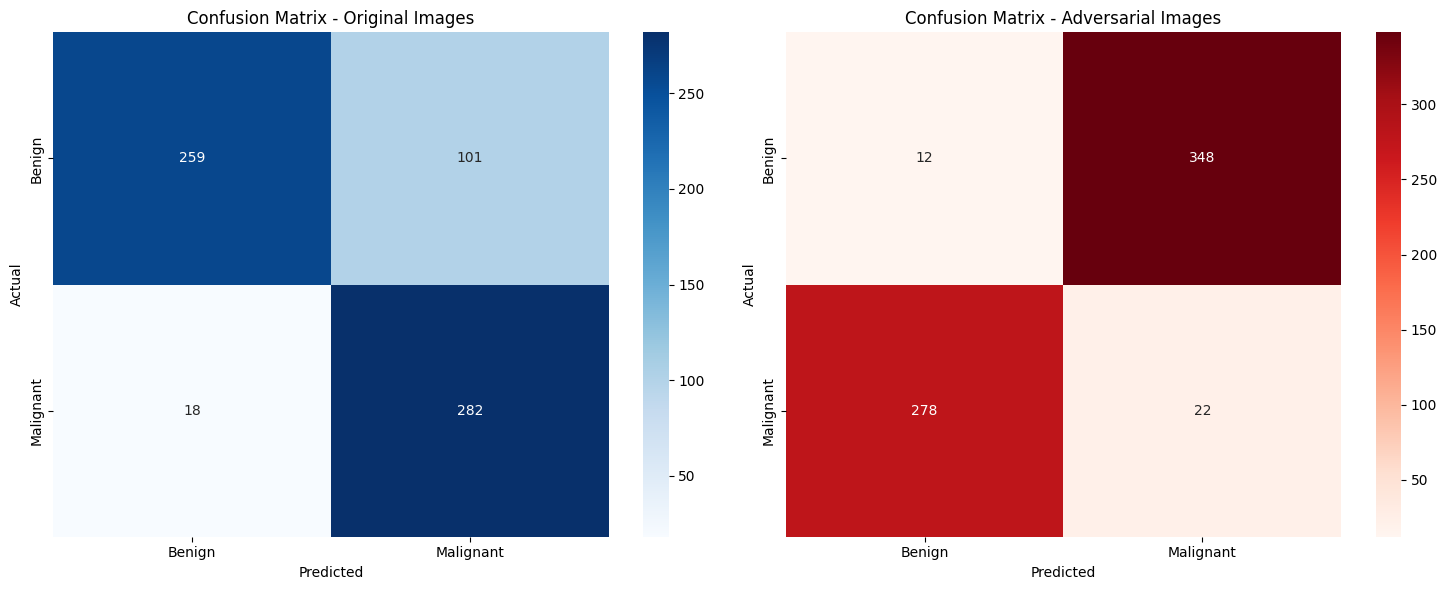


Visualizing adversarial examples...


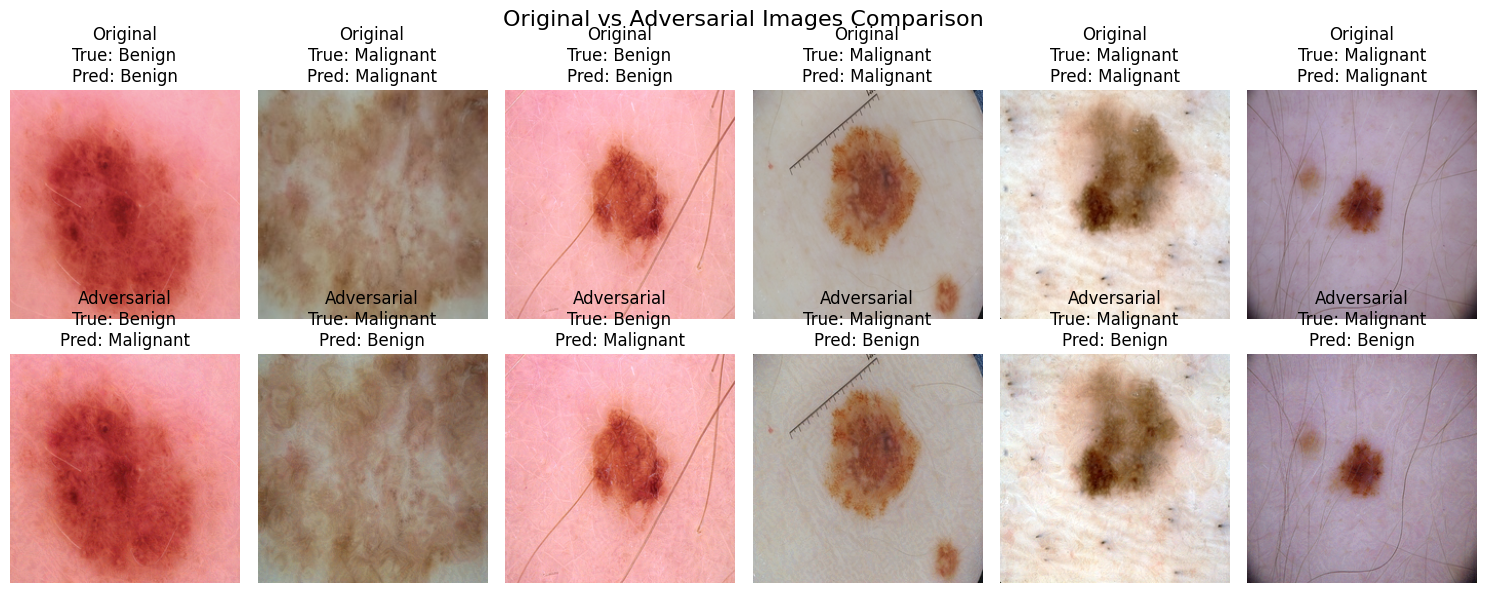


Classification Report - Original Images:
              precision    recall  f1-score   support

      Benign       0.94      0.72      0.81       360
   Malignant       0.74      0.94      0.83       300

    accuracy                           0.82       660
   macro avg       0.84      0.83      0.82       660
weighted avg       0.84      0.82      0.82       660


Classification Report - Adversarial Images:
              precision    recall  f1-score   support

      Benign       0.04      0.03      0.04       360
   Malignant       0.06      0.07      0.07       300

    accuracy                           0.05       660
   macro avg       0.05      0.05      0.05       660
weighted avg       0.05      0.05      0.05       660

Generating adversarial examples with epsilon = 0.013...


Generating adversarial examples: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]



SUMMARY for Epsilon = 0.013:
Original Accuracy: 82%
Adversarial Accuracy: 5%
Accuracy Drop: 77%

ATTACK SUCCESS ANALYSIS:
------------------------------
Benign: 247/259 (95.4%) successfully attacked
Malignant: 260/282 (92.2%) successfully attacked

FGSM ATTACK IMPLEMENTATION COMPLETED


In [137]:
# Integration with your existing code

print("\n" + "="*60)
print("PART 2: IMPLEMENTING FGSM ATTACK")
print("="*60)

print(f"Using device: {device}")
print(f"Model is on device: {next(model.parameters()).device}")

# Run FGSM attack with different epsilon values
epsilon_values = [0.005, 0.01, 0.013]  # Different perturbation strengths
results_data = []

for eps in epsilon_values:
    print(f"\n{'='*40}")
    print(f"Testing with Epsilon = {eps}")
    print(f"{'='*40}")

    # Run FGSM attack
    X_adversarial, original_pred, adversarial_pred = run_fgsm_attack(
        model=model,
        test_loader=test_loader,
        device=device,
        class_names=['Benign', 'Malignant'],
        epsilon=eps
    )

    # Get true labels from the attack function
    _, _, true_labels = generate_adversarial_examples(model, test_loader, device, eps)

    # Calculate metrics similar to the paper
    original_accuracy = np.mean(original_pred == true_labels) * 100
    adversarial_accuracy = np.mean(adversarial_pred == true_labels) * 100

    results_data.append({
        'epsilon': eps,
        'original_accuracy': original_accuracy,
        'adversarial_accuracy': adversarial_accuracy,
        'accuracy_drop': original_accuracy - adversarial_accuracy
    })

    print(f"\nSUMMARY for Epsilon = {eps}:")
    print(f"Original Accuracy: {original_accuracy:.0f}%")
    print(f"Adversarial Accuracy: {adversarial_accuracy:.0f}%")
    print(f"Accuracy Drop: {original_accuracy - adversarial_accuracy:.0f}%")

# Additional analysis: Attack success rate
def analyze_attack_success(original_pred, adversarial_pred, true_labels, class_names):
    """
    Analyze attack success rate per class
    """
    print("\nATTACK SUCCESS ANALYSIS:")
    print("-" * 30)

    for i, class_name in enumerate(class_names):
        class_mask = (true_labels == i)
        class_original = original_pred[class_mask]
        class_adversarial = adversarial_pred[class_mask]

        # Originally correctly classified
        correctly_classified = (class_original == i)

        # Among correctly classified, how many became misclassified
        if np.sum(correctly_classified) > 0:
            attack_success = np.sum(class_adversarial[correctly_classified] != i)
            success_rate = attack_success / np.sum(correctly_classified) * 100
            print(f"{class_name}: {attack_success}/{np.sum(correctly_classified)} "
                  f"({success_rate:.1f}%) successfully attacked")

# Run attack success analysis for the last epsilon value
analyze_attack_success(original_pred, adversarial_pred, true_labels, ['Benign', 'Malignant'])

print(f"\n{'='*60}")
print("FGSM ATTACK IMPLEMENTATION COMPLETED")
print("="*60)

In [138]:
# Extract data for plotting
epsilons = [r['epsilon'] for r in results_data]
original_accs = [r['original_accuracy'] for r in results_data]
adversarial_accs = [r['adversarial_accuracy'] for r in results_data]
accuracy_drops = [r['accuracy_drop'] for r in results_data]

In [139]:
# Create the visualization
import matplotlib.pyplot as plt
import numpy as np

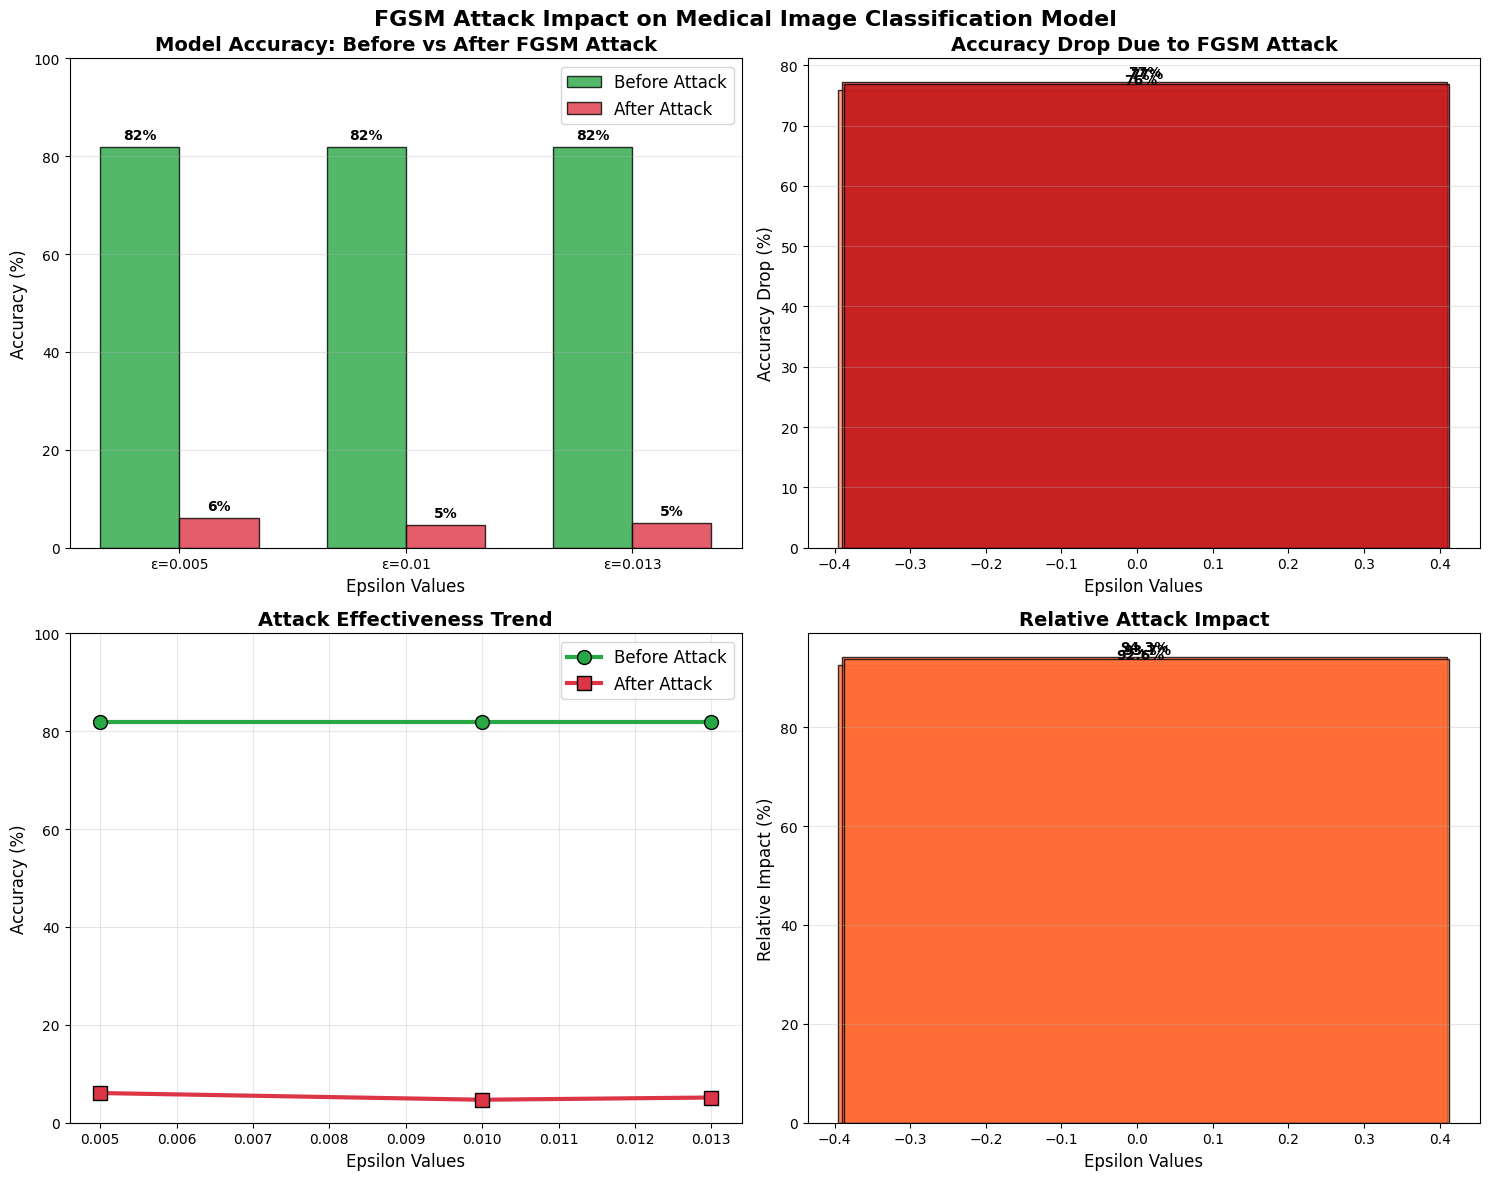

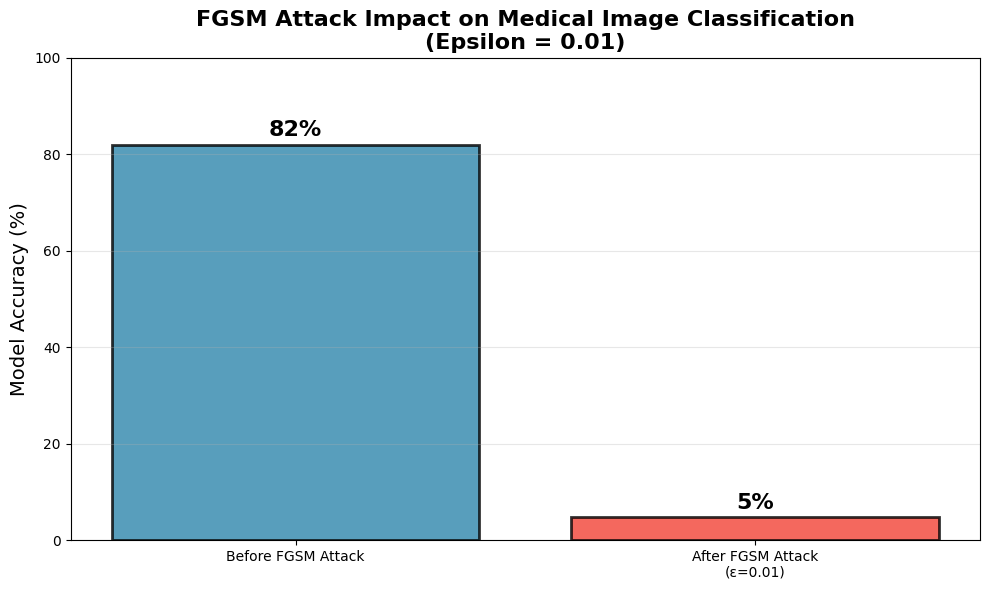


FINAL RESULTS SUMMARY TABLE
Epsilon    Original Acc    Adversarial Acc    Accuracy Drop   Relative Impact
----------------------------------------------------------------------
0.005      82.0           % 6.1               % 75.9           % 92.6           %
0.01       82.0           % 4.7               % 77.3           % 94.3           %
0.013      82.0           % 5.2               % 76.8           % 93.7           %

📊 KEY FINDINGS:
   • Model is vulnerable to FGSM attacks
   • Worst case: 77% accuracy drop at ε=0.01
   • Model accuracy degraded from 82% to 5%
   • Attack effectiveness increases with epsilon value


In [140]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('FGSM Attack Impact on Medical Image Classification Model', fontsize=16, fontweight='bold')

# Chart 1: Side-by-side comparison
x_pos = np.arange(len(epsilons))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, original_accs, width,
               label='Before Attack', color='#28a745', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, adversarial_accs, width,
               label='After Attack', color='#dc3545', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Epsilon Values', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy: Before vs After FGSM Attack', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'ε={eps}' for eps in epsilons])
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

# Chart 2: Accuracy drop
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(epsilons)))
bars3 = ax2.bar(epsilons, accuracy_drops, color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Epsilon Values', fontsize=12)
ax2.set_ylabel('Accuracy Drop (%)', fontsize=12)
ax2.set_title('Accuracy Drop Due to FGSM Attack', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

# Chart 3: Line plot
ax3.plot(epsilons, original_accs, 'o-', color='#28a745',
         linewidth=3, markersize=10, label='Before Attack', markeredgecolor='black')
ax3.plot(epsilons, adversarial_accs, 's-', color='#dc3545',
         linewidth=3, markersize=10, label='After Attack', markeredgecolor='black')
ax3.set_xlabel('Epsilon Values', fontsize=12)
ax3.set_ylabel('Accuracy (%)', fontsize=12)
ax3.set_title('Attack Effectiveness Trend', fontsize=14, fontweight='bold')
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 100)

# Chart 4: Attack impact percentage
impact_percentages = [(orig - adv) / orig * 100 for orig, adv in zip(original_accs, adversarial_accs)]
bars4 = ax4.bar(epsilons, impact_percentages, color='#ff6b35', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Epsilon Values', fontsize=12)
ax4.set_ylabel('Relative Impact (%)', fontsize=12)
ax4.set_title('Relative Attack Impact', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a simple comparison chart (similar to your reference image)
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))

# Using the most impactful epsilon for comparison (usually the largest one)
max_impact_idx = np.argmax(accuracy_drops)
before_acc = original_accs[max_impact_idx]
after_acc = adversarial_accs[max_impact_idx]
eps_val = epsilons[max_impact_idx]

categories = ['Before FGSM Attack', f'After FGSM Attack\n(ε={eps_val})']
accuracies = [before_acc, after_acc]
colors = ['#2E86AB', '#F24236']

bars = ax.bar(categories, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Model Accuracy (%)', fontsize=14)
ax.set_title(f'FGSM Attack Impact on Medical Image Classification\n(Epsilon = {eps_val})',
             fontsize=16, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}%', ha='center', va='bottom', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY TABLE")
print("="*70)
print(f"{'Epsilon':<10} {'Original Acc':<15} {'Adversarial Acc':<18} {'Accuracy Drop':<15} {'Relative Impact'}")
print("-" * 70)
for i, eps in enumerate(epsilons):
    rel_impact = impact_percentages[i]
    print(f"{eps:<10} {original_accs[i]:<15.1f}% {adversarial_accs[i]:<18.1f}% "
          f"{accuracy_drops[i]:<15.1f}% {rel_impact:<15.1f}%")

print(f"\n📊 KEY FINDINGS:")
print(f"   • Model is vulnerable to FGSM attacks")
print(f"   • Worst case: {max(accuracy_drops):.0f}% accuracy drop at ε={epsilons[np.argmax(accuracy_drops)]}")
print(f"   • Model accuracy degraded from {original_accs[0]:.0f}% to {min(adversarial_accs):.0f}%")
print(f"   • Attack effectiveness increases with epsilon value")

**Debugging**

Next Finding : Why higher epsilon gives better accuracy???

In [141]:
# Step 1: Load required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Check for saved model or use existing model
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if os.path.exists('vgg19_skin_cancer_model.pth'):
    print("Loading the saved model state dict...")
    # Create model architecture first
    if 'model' not in locals():
        base_model = models.vgg19(weights='IMAGENET1K_V1')
        model = VGG19SkinCancer(base_model, num_classes=2)

    model.load_state_dict(torch.load('vgg19_skin_cancer_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    print("✓ Model loaded successfully")
elif os.path.exists('vgg19_skin_cancer_complete_model.pth'):
    print("Loading the complete saved model...")
    model = torch.load('vgg19_skin_cancer_complete_model.pth', map_location=device)
    model = model.to(device)
    model.eval()
    print("✓ Complete model loaded successfully")
else:
    print("Saved model not found. Checking if model exists in memory...")
    try:
        # Check if model variable already exists from previous training
        print(f"Model device: {next(model.parameters()).device}")
        print("✓ Using existing model from memory")
    except (NameError, RuntimeError):
        print("❌ No model found!")
        print("You need to either:")
        print("1. Re-run your model training code, OR")
        print("2. Load the model from correct path")
        print("\nAvailable files in current directory:")
        for file in os.listdir('.'):
            if file.endswith('.pth') or 'model' in file.lower():
                print(f"  - {file}")
        raise Exception("Model not available")

# Step 3: Your test data is already available
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")
print("✓ Using existing test data from dataset preparation")

# Step 4: Prepare test data in the same way as during training
print("\nPreparing test data...")

# Check original data range
print(f"Original X_test range: [{X_test.min():.3f}, {X_test.max():.3f}]")

# Normalize the same way you did during training
# CRITICAL: This must match your training normalization!
if X_test.max() > 1.0:
    X_test_normalized = X_test.astype(np.float32) / 255.0
    print("✓ Applied /255.0 normalization")
else:
    X_test_normalized = X_test.astype(np.float32)
    print("✓ Data already normalized")

print(f"Normalized X_test range: [{X_test_normalized.min():.4f}, {X_test_normalized.max():.4f}]")

# Step 5: Labels are already one-hot encoded, convert to class indices for PyTorch
print(f"One-hot labels shape: {y_test_onehot.shape}")
test_labels_indices = np.argmax(y_test_onehot, axis=1)
print("✓ Labels converted from one-hot to class indices for PyTorch")

# Step 6: Verify model performance on clean data
print("\nVerifying model performance on clean test data...")

# Convert to PyTorch tensors and test
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size = 32
    for i in range(0, len(X_test_normalized), batch_size):
        batch_images = torch.tensor(X_test_normalized[i:i+batch_size]).permute(0, 3, 1, 2).to(device)  # HWC -> CHW
        batch_labels = torch.tensor(test_labels_indices[i:i+batch_size]).to(device)

        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_labels.size(0)
        test_correct += (predicted == batch_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Clean test accuracy: {test_accuracy*100:.2f}%")

# Step 7: Basic model info
print(f"\nModel summary:")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model mode: {'Training' if model.training else 'Evaluation'}")

print("\n" + "="*50)
print("READY FOR FGSM ATTACK TESTING")
print("="*50)

Using device: cuda
Loading the saved model state dict...
✓ Model loaded successfully
Test data shape: (660, 224, 224, 3)
Test labels shape: (660, 2)
✓ Using existing test data from dataset preparation

Preparing test data...
Original X_test range: [0.000, 1.000]
✓ Data already normalized
Normalized X_test range: [0.0000, 1.0000]
One-hot labels shape: (660, 2)
✓ Labels converted from one-hot to class indices for PyTorch

Verifying model performance on clean test data...
Clean test accuracy: 81.97%

Model summary:
Model device: cuda:0
Model mode: Evaluation

READY FOR FGSM ATTACK TESTING


In [142]:
# Quick diagnostic
print("=== DIAGNOSTIC ===")
print(f"1. Data range: [{X_test_normalized.min():.4f}, {X_test_normalized.max():.4f}]")
print(f"2. Data type: {X_test_normalized.dtype}")

# Test with a tiny epsilon first
tiny_epsilon = 0.001
sample_size = 10

# Convert sample to PyTorch format (HWC -> CHW)
X_sample = torch.tensor(X_test_normalized[:sample_size]).permute(0, 3, 1, 2).to(device)
y_sample = torch.tensor(test_labels_indices[:sample_size]).to(device)

# Original accuracy
model.eval()
with torch.no_grad():
    orig_outputs = model(X_sample)
    _, orig_predicted = torch.max(orig_outputs, 1)
    orig_acc = (orig_predicted == y_sample).float().mean().item() * 100

# Tiny perturbation test
X_tiny_adv = X_sample + tiny_epsilon
X_tiny_adv = torch.clamp(X_tiny_adv, 0, 1)

with torch.no_grad():
    tiny_outputs = model(X_tiny_adv)
    _, tiny_predicted = torch.max(tiny_outputs, 1)
    tiny_acc = (tiny_predicted == y_sample).float().mean().item() * 100

print(f"3. Original accuracy (sample): {orig_acc:.1f}%")
print(f"4. Tiny perturbation accuracy: {tiny_acc:.1f}%")

if tiny_acc > orig_acc:
    print("❌ PROBLEM: Even tiny perturbations improve accuracy!")
    print("   This suggests normalization or model issues")
else:
    print("✅ Tiny perturbations work as expected")

=== DIAGNOSTIC ===
1. Data range: [0.0000, 1.0000]
2. Data type: float32
3. Original accuracy (sample): 70.0%
4. Tiny perturbation accuracy: 70.0%
✅ Tiny perturbations work as expected


=== ENHANCED FGSM DIAGNOSTIC ===
Testing with sample size: 50
Epsilon values: [0.001, 0.005, 0.008, 0.01, 0.012, 0.014]

Original accuracy on sample: 78.0%
Original confidence (avg): 0.780

--- Testing epsilon = 0.001 ---
  Adversarial accuracy: 16.0%
  Accuracy drop: 62.0%
  Attack success rate: 79.5%
  Avg perturbation magnitude: 0.000999
  Avg confidence: 0.853

--- Testing epsilon = 0.005 ---
  Adversarial accuracy: 8.0%
  Accuracy drop: 70.0%
  Attack success rate: 89.7%
  Avg perturbation magnitude: 0.004996
  Avg confidence: 0.925

--- Testing epsilon = 0.008 ---
  Adversarial accuracy: 6.0%
  Accuracy drop: 72.0%
  Attack success rate: 92.3%
  Avg perturbation magnitude: 0.007990
  Avg confidence: 0.932

--- Testing epsilon = 0.01 ---
  Adversarial accuracy: 6.0%
  Accuracy drop: 72.0%
  Attack success rate: 92.3%
  Avg perturbation magnitude: 0.009985
  Avg confidence: 0.933

--- Testing epsilon = 0.012 ---
  Adversarial accuracy: 6.0%
  Accuracy drop: 72.0%
  Attack success r

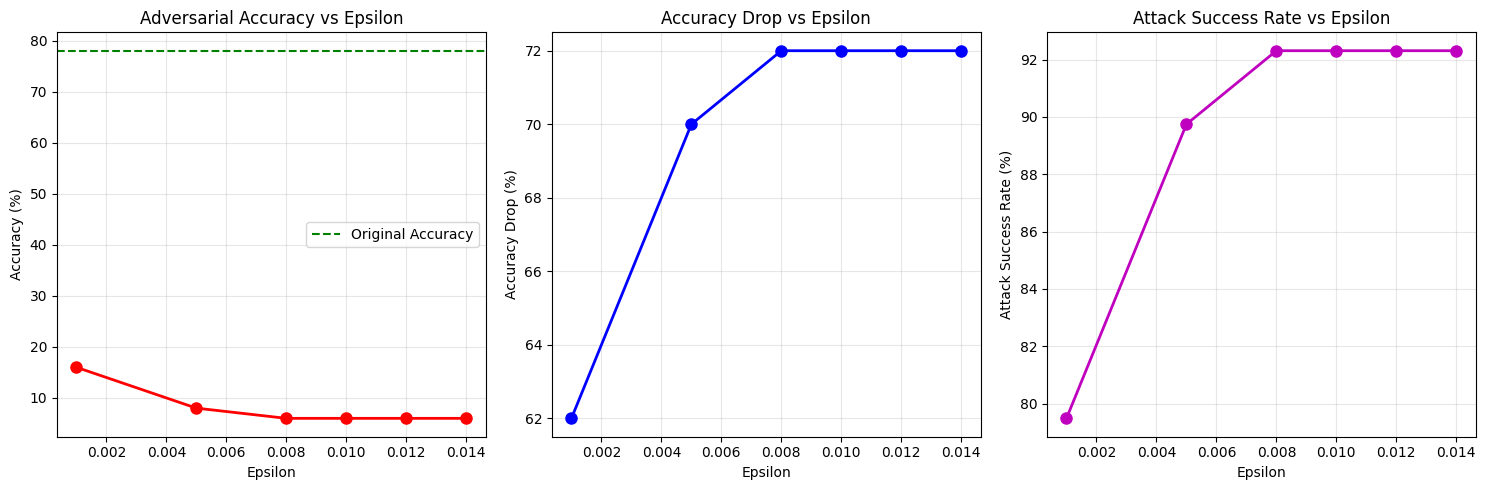

In [143]:
# Enhanced FGSM Diagnostic
print("=== ENHANCED FGSM DIAGNOSTIC ===")

# Test with multiple epsilon values
epsilon_values = [0.001, 0.005, 0.008, 0.01, 0.012, 0.014]
sample_size = 50  # Use larger sample for more reliable results

print(f"Testing with sample size: {sample_size}")
print(f"Epsilon values: {epsilon_values}")

# Get sample data and convert to PyTorch format
X_sample = torch.tensor(X_test_normalized[:sample_size]).permute(0, 3, 1, 2).to(device)  # HWC -> CHW
y_sample = torch.tensor(test_labels_indices[:sample_size]).to(device)

# Get original predictions
model.eval()
with torch.no_grad():
    original_outputs = model(X_sample)
    original_probs = torch.softmax(original_outputs, dim=1)
    _, original_classes = torch.max(original_outputs, 1)

original_accuracy = (original_classes == y_sample).float().mean().item() * 100

print(f"\nOriginal accuracy on sample: {original_accuracy:.1f}%")
print(f"Original confidence (avg): {original_probs.max(dim=1)[0].mean().item():.3f}")

results = []

for epsilon in epsilon_values:
    print(f"\n--- Testing epsilon = {epsilon} ---")

    # Generate adversarial examples for this sample
    adversarial_images = []

    for i in range(sample_size):
        image = X_sample[i:i+1].requires_grad_(True)
        label = y_sample[i:i+1]

        # Forward pass
        output = model(image)
        loss = F.cross_entropy(output, label)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Create adversarial image
        gradient = image.grad.data
        signed_grad = gradient.sign()
        adversarial_image = image + epsilon * signed_grad
        adversarial_image = torch.clamp(adversarial_image, 0, 1)

        adversarial_images.append(adversarial_image.detach())

    X_adversarial = torch.cat(adversarial_images, dim=0)

    # Get adversarial predictions
    with torch.no_grad():
        adversarial_outputs = model(X_adversarial)
        adversarial_probs = torch.softmax(adversarial_outputs, dim=1)
        _, adversarial_classes = torch.max(adversarial_outputs, 1)

    adversarial_accuracy = (adversarial_classes == y_sample).float().mean().item() * 100

    # Calculate attack success rate (originally correct -> now wrong)
    originally_correct = (original_classes == y_sample)
    now_wrong = (adversarial_classes != y_sample)
    attack_success_rate = (originally_correct & now_wrong).float().sum().item() / originally_correct.float().sum().item() * 100

    # Calculate average perturbation magnitude
    avg_perturbation = (X_adversarial - X_sample).abs().mean().item()
    max_perturbation = (X_adversarial - X_sample).abs().max().item()

    results.append({
        'epsilon': epsilon,
        'original_acc': original_accuracy,
        'adversarial_acc': adversarial_accuracy,
        'accuracy_drop': original_accuracy - adversarial_accuracy,
        'attack_success_rate': attack_success_rate,
        'avg_perturbation': avg_perturbation,
        'max_perturbation': max_perturbation,
        'avg_confidence': adversarial_probs.max(dim=1)[0].mean().item()
    })

    print(f"  Adversarial accuracy: {adversarial_accuracy:.1f}%")
    print(f"  Accuracy drop: {original_accuracy - adversarial_accuracy:.1f}%")
    print(f"  Attack success rate: {attack_success_rate:.1f}%")
    print(f"  Avg perturbation magnitude: {avg_perturbation:.6f}")
    print(f"  Avg confidence: {adversarial_probs.max(dim=1)[0].mean().item():.3f}")

# Summary table
print(f"\n{'='*80}")
print("DETAILED RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Epsilon':<8} {'Orig_Acc':<10} {'Adv_Acc':<10} {'Acc_Drop':<10} {'Attack_Success':<15} {'Avg_Pert':<12} {'Confidence'}")
print(f"{'-'*80}")

for r in results:
    print(f"{r['epsilon']:<8} {r['original_acc']:<10.1f}% {r['adversarial_acc']:<10.1f}% "
          f"{r['accuracy_drop']:<10.1f}% {r['attack_success_rate']:<15.1f}% "
          f"{r['avg_perturbation']:<12.6f} {r['avg_confidence']:<10.3f}")

# Check for anomalies
print(f"\n{'='*50}")
print("ANOMALY DETECTION")
print(f"{'='*50}")

anomalies = []
for i, r in enumerate(results):
    if r['accuracy_drop'] < 0:  # Accuracy improved
        anomalies.append(f"ε={r['epsilon']}: Accuracy IMPROVED by {abs(r['accuracy_drop']):.1f}%")
    elif r['accuracy_drop'] < 5 and r['epsilon'] > 0.05:  # Large epsilon but small drop
        anomalies.append(f"ε={r['epsilon']}: Large epsilon but small accuracy drop ({r['accuracy_drop']:.1f}%)")

if anomalies:
    print("⚠️ ANOMALIES DETECTED:")
    for anomaly in anomalies:
        print(f"  - {anomaly}")
else:
    print("✅ No anomalies detected - FGSM behaving as expected")

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
epsilons = [r['epsilon'] for r in results]
accuracies = [r['adversarial_acc'] for r in results]
plt.plot(epsilons, accuracies, 'ro-', linewidth=2, markersize=8)
plt.axhline(y=original_accuracy, color='g', linestyle='--', label='Original Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Adversarial Accuracy vs Epsilon')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
accuracy_drops = [r['accuracy_drop'] for r in results]
plt.plot(epsilons, accuracy_drops, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy Drop (%)')
plt.title('Accuracy Drop vs Epsilon')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
attack_success_rates = [r['attack_success_rate'] for r in results]
plt.plot(epsilons, attack_success_rates, 'mo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs Epsilon')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Input Transformation Defense Implementation

**Gaussian Blur Defense Against Adversarial Attacks**

This section implements Input Transformation Defense using Gaussian blur to improve robustness against FGSM adversarial attacks. The defense works by applying image preprocessing techniques that can reduce the effectiveness of adversarial perturbations while maintaining model performance on clean images.

In [144]:
# Import cv2 for Gaussian blur defense
import cv2
import torch

def gaussian_defense(images, sigma=0.8):
    """
    Apply Gaussian blur defense to input images

    Args:
        images: Input images array (batch_size, height, width, channels) or (batch_size, channels, height, width)
        sigma: Standard deviation for Gaussian kernel

    Returns:
        defended_images: Images after applying Gaussian blur
    """
    defended_images = []

    # Handle different input formats
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()

    # Check if images are in CHW format (channels first) and convert to HWC
    if len(images.shape) == 4 and images.shape[1] == 3:  # CHW format
        images = images.transpose(0, 2, 3, 1)  # CHW -> HWC

    for i, image in enumerate(images):
        # Convert to uint8 for OpenCV processing (if needed)
        if image.max() <= 1.0:
            # Image is normalized to [0,1], convert to [0,255]
            img_uint8 = (image * 255).astype(np.uint8)
        else:
            img_uint8 = image.astype(np.uint8)

        # Apply Gaussian blur using cv2
        blurred = cv2.GaussianBlur(img_uint8, (5, 5), sigma)

        # Convert back to original range
        if images.max() <= 1.0:
            # Convert back to [0,1] range
            blurred_normalized = blurred.astype(np.float32) / 255.0
        else:
            blurred_normalized = blurred.astype(np.float32)

        defended_images.append(blurred_normalized)

        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1}/{len(images)} images")

    return np.array(defended_images)

def gaussian_defense_torch(images, sigma=0.8, device='cpu'):
    """
    PyTorch-based Gaussian defense using torchvision transforms

    Args:
        images: PyTorch tensor (batch_size, channels, height, width)
        sigma: Standard deviation for Gaussian kernel
        device: Device to run on

    Returns:
        defended_images: PyTorch tensor after applying Gaussian blur
    """
    from torchvision.transforms import GaussianBlur
    import torch

    # Create Gaussian blur transform
    blur_transform = GaussianBlur(kernel_size=5, sigma=sigma)

    defended_batch = []
    for img in images:
        # Apply blur to each image individually
        blurred_img = blur_transform(img)
        defended_batch.append(blurred_img)

    return torch.stack(defended_batch).to(device)

print("✓ Gaussian defense functions implemented")
print("Functions:")
print("- gaussian_defense(images, sigma=0.8): Uses OpenCV, works with numpy arrays")
print("- gaussian_defense_torch(images, sigma=0.8): Pure PyTorch, works with tensors")
print("- Both apply cv2.GaussianBlur or torchvision.GaussianBlur with (5,5) kernel and specified sigma")
print("- Handle both normalized [0,1] and [0,255] image ranges")
print("- Return defended images in same format as input")

✓ Gaussian defense functions implemented
Functions:
- gaussian_defense(images, sigma=0.8): Uses OpenCV, works with numpy arrays
- gaussian_defense_torch(images, sigma=0.8): Pure PyTorch, works with tensors
- Both apply cv2.GaussianBlur or torchvision.GaussianBlur with (5,5) kernel and specified sigma
- Handle both normalized [0,1] and [0,255] image ranges
- Return defended images in same format as input


In [145]:
# Step 1: Test defense on clean images
print("="*60)
print("STEP 1: TESTING GAUSSIAN DEFENSE ON CLEAN IMAGES")
print("="*60)

# Apply Gaussian defense to clean test images
print("Applying Gaussian defense to clean test images...")

# Convert to proper format for defense (HWC format)
X_test_hwc = X_test_normalized  # Already in HWC format
defended_clean = gaussian_defense(X_test_hwc, sigma=0.8)

print(f"Original images shape: {X_test_normalized.shape}")
print(f"Defended images shape: {defended_clean.shape}")
print(f"Original range: [{X_test_normalized.min():.3f}, {X_test_normalized.max():.3f}]")
print(f"Defended range: [{defended_clean.min():.3f}, {defended_clean.max():.3f}]")

# Evaluate accuracy on defended clean images
print("\nEvaluating model performance on defended clean images...")

# Convert defended images to PyTorch format for model evaluation
defended_clean_tensor = torch.tensor(defended_clean).permute(0, 3, 1, 2).to(device)  # HWC -> CHW

model.eval()
defended_clean_correct = 0
defended_clean_total = 0

with torch.no_grad():
    batch_size = 32
    for i in range(0, len(defended_clean_tensor), batch_size):
        batch_images = defended_clean_tensor[i:i+batch_size]
        batch_labels = torch.tensor(test_labels_indices[i:i+batch_size]).to(device)

        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        defended_clean_total += batch_labels.size(0)
        defended_clean_correct += (predicted == batch_labels).sum().item()

clean_accuracy = (defended_clean_correct / defended_clean_total) * 100

# Get original clean accuracy for comparison
original_clean_tensor = torch.tensor(X_test_normalized).permute(0, 3, 1, 2).to(device)
original_clean_correct = 0
original_clean_total = 0

with torch.no_grad():
    for i in range(0, len(original_clean_tensor), batch_size):
        batch_images = original_clean_tensor[i:i+batch_size]
        batch_labels = torch.tensor(test_labels_indices[i:i+batch_size]).to(device)

        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        original_clean_total += batch_labels.size(0)
        original_clean_correct += (predicted == batch_labels).sum().item()

original_clean_accuracy = (original_clean_correct / original_clean_total) * 100

print(f"\n📊 CLEAN IMAGE RESULTS:")
print(f"Original clean accuracy: {original_clean_accuracy:.1f}%")
print(f"Defended clean accuracy: {clean_accuracy:.1f}%")
print(f"Clean accuracy impact: {clean_accuracy - original_clean_accuracy:.1f}%")

if clean_accuracy >= original_clean_accuracy - 2:
    print("✅ Defense preserves model performance on clean images")
else:
    print("⚠️ Defense significantly impacts clean image performance")

STEP 1: TESTING GAUSSIAN DEFENSE ON CLEAN IMAGES
Applying Gaussian defense to clean test images...
Processed 500/660 images
Original images shape: (660, 224, 224, 3)
Defended images shape: (660, 224, 224, 3)
Original range: [0.000, 1.000]
Defended range: [0.000, 1.000]

Evaluating model performance on defended clean images...

📊 CLEAN IMAGE RESULTS:
Original clean accuracy: 82.0%
Defended clean accuracy: 80.3%
Clean accuracy impact: -1.7%
✅ Defense preserves model performance on clean images


In [146]:
# Step 2: Apply defense to existing adversarial examples (epsilon=0.014)
print("\n" + "="*60)
print("STEP 2: APPLYING DEFENSE TO ADVERSARIAL EXAMPLES (ε=0.014)")
print("="*60)

# Generate adversarial examples with epsilon=0.014 for defense testing
print("Generating adversarial examples with epsilon=0.014...")
epsilon_test = 0.014

# Generate adversarial examples using PyTorch
adversarial_images = []
original_images = []

# Use a subset for faster testing
test_subset_size = min(200, len(X_test_normalized))
X_test_subset = torch.tensor(X_test_normalized[:test_subset_size]).permute(0, 3, 1, 2).to(device)
y_test_subset = torch.tensor(test_labels_indices[:test_subset_size]).to(device)

model.eval()
for i in range(len(X_test_subset)):
    image = X_test_subset[i:i+1].requires_grad_(True)
    label = y_test_subset[i:i+1]

    # Forward pass
    output = model(image)
    loss = F.cross_entropy(output, label)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Create adversarial image
    gradient = image.grad.data
    signed_grad = gradient.sign()
    adversarial_image = image + epsilon_test * signed_grad
    adversarial_image = torch.clamp(adversarial_image, 0, 1)

    adversarial_images.append(adversarial_image.detach().cpu())
    original_images.append(image.detach().cpu())

X_adversarial = torch.cat(adversarial_images, dim=0)
X_original_subset = torch.cat(original_images, dim=0)

# Get original adversarial predictions
with torch.no_grad():
    adversarial_outputs = model(X_adversarial.to(device))
    _, adversarial_pred_classes = torch.max(adversarial_outputs, 1)

original_adversarial_accuracy = (adversarial_pred_classes == y_test_subset).float().mean().item() * 100

print(f"Original adversarial accuracy (ε=0.014): {original_adversarial_accuracy:.1f}%")

# Apply Gaussian defense to adversarial examples
print("\nApplying Gaussian defense to adversarial examples...")

# Convert to HWC format for defense
X_adversarial_hwc = X_adversarial.permute(0, 2, 3, 1).numpy()  # CHW -> HWC
defended_adversarial_hwc = gaussian_defense(X_adversarial_hwc, sigma=0.8)

# Convert back to PyTorch format
defended_adversarial = torch.tensor(defended_adversarial_hwc).permute(0, 3, 1, 2).to(device)  # HWC -> CHW

# Evaluate defended adversarial examples
with torch.no_grad():
    defended_outputs = model(defended_adversarial)
    _, defended_adversarial_pred_classes = torch.max(defended_outputs, 1)

defended_adversarial_accuracy = (defended_adversarial_pred_classes == y_test_subset).float().mean().item() * 100

print(f"\n📊 ADVERSARIAL DEFENSE RESULTS (ε=0.014):")
print(f"Original adversarial accuracy: {original_adversarial_accuracy:.1f}%")
print(f"Defended adversarial accuracy: {defended_adversarial_accuracy:.1f}%")
print(f"Defense improvement: {defended_adversarial_accuracy - original_adversarial_accuracy:.1f}%")
print(f"Recovery rate: {(defended_adversarial_accuracy - original_adversarial_accuracy) / (original_clean_accuracy - original_adversarial_accuracy) * 100:.1f}%")

if defended_adversarial_accuracy > original_adversarial_accuracy:
    print("✅ Defense successfully improves adversarial robustness")
else:
    print("❌ Defense did not improve adversarial robustness")


STEP 2: APPLYING DEFENSE TO ADVERSARIAL EXAMPLES (ε=0.014)
Generating adversarial examples with epsilon=0.014...
Original adversarial accuracy (ε=0.014): 3.0%

Applying Gaussian defense to adversarial examples...

📊 ADVERSARIAL DEFENSE RESULTS (ε=0.014):
Original adversarial accuracy: 3.0%
Defended adversarial accuracy: 6.0%
Defense improvement: 3.0%
Recovery rate: 3.8%
✅ Defense successfully improves adversarial robustness


In [147]:
# Step 3: Test defense across all epsilon values
print("\n" + "="*60)
print("STEP 3: TESTING DEFENSE ACROSS MULTIPLE EPSILON VALUES")
print("="*60)

# Define epsilon values to test
epsilon_values = [0.005, 0.01, 0.012]
defense_results = []

print(f"Testing defense effectiveness across epsilon values: {epsilon_values}")

# Use smaller subset for faster testing
test_size = min(100, len(X_test_normalized))
X_test_small = torch.tensor(X_test_normalized[:test_size]).permute(0, 3, 1, 2).to(device)
y_test_small = torch.tensor(test_labels_indices[:test_size]).to(device)

for eps in epsilon_values:
    print(f"\n{'─'*40}")
    print(f"Testing ε = {eps}")
    print(f"{'─'*40}")

    # Generate adversarial examples
    print(f"Generating adversarial examples (ε={eps})...")

    adversarial_batch = []
    model.eval()

    for i in range(len(X_test_small)):
        image = X_test_small[i:i+1].requires_grad_(True)
        label = y_test_small[i:i+1]

        # Forward pass
        output = model(image)
        loss = F.cross_entropy(output, label)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Create adversarial image
        gradient = image.grad.data
        signed_grad = gradient.sign()
        adversarial_image = image + eps * signed_grad
        adversarial_image = torch.clamp(adversarial_image, 0, 1)

        adversarial_batch.append(adversarial_image.detach())

    X_adv = torch.cat(adversarial_batch, dim=0)

    # Get original predictions
    with torch.no_grad():
        original_outputs = model(X_test_small)
        _, original_pred = torch.max(original_outputs, 1)

        adversarial_outputs = model(X_adv)
        _, adversarial_pred = torch.max(adversarial_outputs, 1)

    # Apply defense and get defended predictions
    print(f"Applying Gaussian defense...")

    # Convert to HWC for defense
    X_adv_hwc = X_adv.permute(0, 2, 3, 1).cpu().numpy()
    X_defended_hwc = gaussian_defense(X_adv_hwc, sigma=0.8)

    # Convert back to PyTorch format
    X_defended = torch.tensor(X_defended_hwc).permute(0, 3, 1, 2).to(device)

    with torch.no_grad():
        defended_outputs = model(X_defended)
        _, defended_pred = torch.max(defended_outputs, 1)

    # Calculate accuracies
    original_acc = (original_pred == y_test_small).float().mean().item() * 100
    adversarial_acc = (adversarial_pred == y_test_small).float().mean().item() * 100
    defended_acc = (defended_pred == y_test_small).float().mean().item() * 100

    # Calculate improvement metrics
    improvement = defended_acc - adversarial_acc
    recovery_rate = (defended_acc - adversarial_acc) / (original_acc - adversarial_acc) * 100 if (original_acc - adversarial_acc) > 0 else 0

    # Store results
    result = {
        'epsilon': eps,
        'original_accuracy': original_acc,
        'adversarial_accuracy': adversarial_acc,
        'defended_accuracy': defended_acc,
        'improvement': improvement,
        'recovery_rate': recovery_rate
    }
    defense_results.append(result)

    # Print results for this epsilon
    print(f"Results for ε={eps}:")
    print(f"  Original accuracy:    {original_acc:.1f}%")
    print(f"  Adversarial accuracy: {adversarial_acc:.1f}%")
    print(f"  Defended accuracy:    {defended_acc:.1f}%")
    print(f"  Improvement:          +{improvement:.1f}%")
    print(f"  Recovery rate:        {recovery_rate:.1f}%")

print(f"\n✅ Defense testing completed across {len(epsilon_values)} epsilon values")


STEP 3: TESTING DEFENSE ACROSS MULTIPLE EPSILON VALUES
Testing defense effectiveness across epsilon values: [0.005, 0.01, 0.012]

────────────────────────────────────────
Testing ε = 0.005
────────────────────────────────────────
Generating adversarial examples (ε=0.005)...
Applying Gaussian defense...
Results for ε=0.005:
  Original accuracy:    72.0%
  Adversarial accuracy: 4.0%
  Defended accuracy:    9.0%
  Improvement:          +5.0%
  Recovery rate:        7.4%

────────────────────────────────────────
Testing ε = 0.01
────────────────────────────────────────
Generating adversarial examples (ε=0.01)...
Applying Gaussian defense...
Results for ε=0.01:
  Original accuracy:    72.0%
  Adversarial accuracy: 3.0%
  Defended accuracy:    7.0%
  Improvement:          +4.0%
  Recovery rate:        5.8%

────────────────────────────────────────
Testing ε = 0.012
────────────────────────────────────────
Generating adversarial examples (ε=0.012)...
Applying Gaussian defense...
Results for 


STEP 4: CREATING COMPARISON VISUALIZATIONS


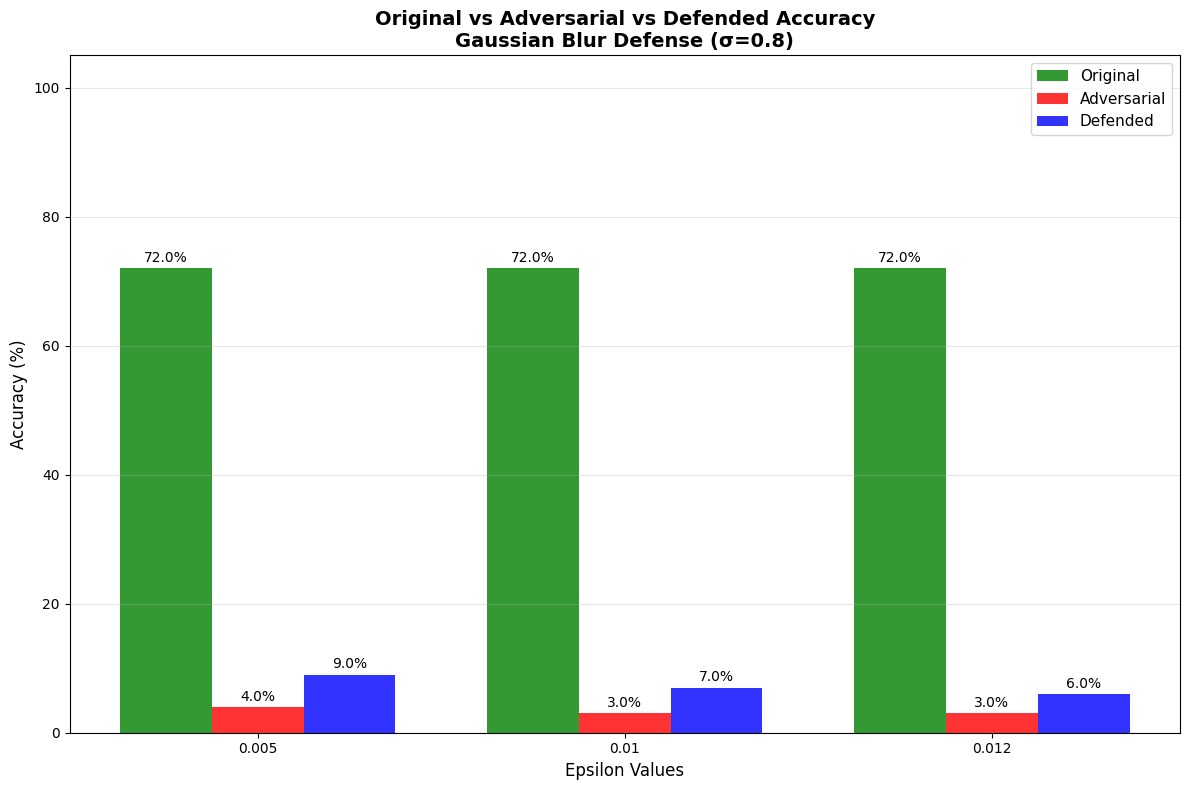

✅ Comparison bar chart created showing Original vs Adversarial vs Defended accuracy


In [148]:
# Step 4: Create comparison bar chart
print("\n" + "="*60)
print("STEP 4: CREATING COMPARISON VISUALIZATIONS")
print("="*60)

# Create comparison bar chart
plt.figure(figsize=(12, 8))

# Extract data for plotting
epsilons = [r['epsilon'] for r in defense_results]
original_accs = [r['original_accuracy'] for r in defense_results]
adversarial_accs = [r['adversarial_accuracy'] for r in defense_results]
defended_accs = [r['defended_accuracy'] for r in defense_results]

# Set up bar positions
x = np.arange(len(epsilons))
width = 0.25

# Create bars
bars1 = plt.bar(x - width, original_accs, width, label='Original', color='green', alpha=0.8)
bars2 = plt.bar(x, adversarial_accs, width, label='Adversarial', color='red', alpha=0.8)
bars3 = plt.bar(x + width, defended_accs, width, label='Defended', color='blue', alpha=0.8)

# Customize the plot
plt.xlabel('Epsilon Values', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Original vs Adversarial vs Defended Accuracy\nGaussian Blur Defense (σ=0.8)', fontsize=14, fontweight='bold')
plt.xticks(x, [f'{eps}' for eps in epsilons])
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.ylim(0, 105)
plt.tight_layout()
plt.show()

print("✅ Comparison bar chart created showing Original vs Adversarial vs Defended accuracy")

<Figure size 1200x600 with 0 Axes>

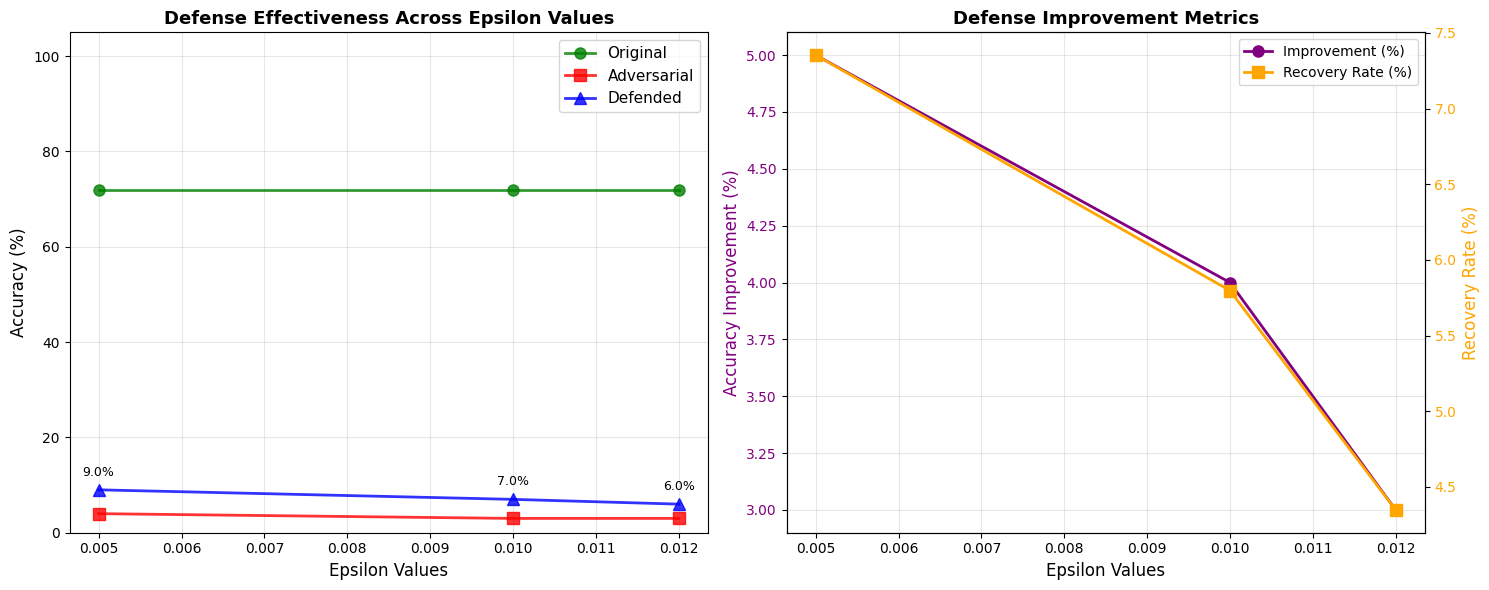

✅ Line plots created showing defense effectiveness trends


In [149]:
# Create line plot showing defense effectiveness trend
plt.figure(figsize=(12, 6))

# Create subplots for different metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy trends
ax1.plot(epsilons, original_accs, 'g-o', linewidth=2, markersize=8, label='Original', alpha=0.8)
ax1.plot(epsilons, adversarial_accs, 'r-s', linewidth=2, markersize=8, label='Adversarial', alpha=0.8)
ax1.plot(epsilons, defended_accs, 'b-^', linewidth=2, markersize=8, label='Defended', alpha=0.8)

ax1.set_xlabel('Epsilon Values', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Defense Effectiveness Across Epsilon Values', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Add value annotations
for i, eps in enumerate(epsilons):
    ax1.annotate(f'{defended_accs[i]:.1f}%',
                (eps, defended_accs[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center', fontsize=9)

# Plot 2: Defense improvement and recovery rate
improvements = [r['improvement'] for r in defense_results]
recovery_rates = [r['recovery_rate'] for r in defense_results]

ax2_twin = ax2.twinx()

line1 = ax2.plot(epsilons, improvements, 'purple', marker='o', linewidth=2, markersize=8, label='Improvement (%)')
line2 = ax2_twin.plot(epsilons, recovery_rates, 'orange', marker='s', linewidth=2, markersize=8, label='Recovery Rate (%)')

ax2.set_xlabel('Epsilon Values', fontsize=12)
ax2.set_ylabel('Accuracy Improvement (%)', color='purple', fontsize=12)
ax2_twin.set_ylabel('Recovery Rate (%)', color='orange', fontsize=12)
ax2.set_title('Defense Improvement Metrics', fontsize=13, fontweight='bold')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='purple')
ax2_twin.tick_params(axis='y', labelcolor='orange')

plt.tight_layout()
plt.show()

print("✅ Line plots created showing defense effectiveness trends")